In [1]:
import pandas as pd
import matplotlib
import warnings
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import analysis_utils

# path to predictions folder (stored in repository by default)
# unexpected behavior might occur if you use another location
path = '/home/sareeves/thermostability-transfer'
preds_loc = os.path.join(path, 'data', 'fireprot_mapped_preds_original.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

In [2]:
### load and preprocess data

# load main data
db = pd.read_csv(preds_loc, index_col=0)
# don't assume that anything except the uids and predictions are in the preds file
db2 = pd.read_csv(os.path.join(path, 'data', 'fireprot_mapped.csv'), index_col=0)
db2 = db2[[col for col in db2.columns if col not in db.columns]]
# join the predictions with the original FireProt information
db = db.join(db2, how='right')

# get only curated mutations for all future analyses
#db = db.loc[db['is_curated']]
#print(len(db))

db['mpnn_mean_dir'] = db[['mpnn_10_00_dir', 'mpnn_20_00_dir', 'mpnn_30_00_dir']].mean(axis=1)
db['runtime_mpnn_mean_dir'] = db[['runtime_mpnn_10_00_dir', 'runtime_mpnn_20_00_dir', 'runtime_mpnn_30_00_dir']].sum(axis=1)

# drop locations with no indicated position
db = db.dropna(subset=['position'])

# uid (specified in preprocessing) is the index for this database
db = db.reset_index().rename({'index': 'uid'}, axis=1)

# extract information about data origins
db['ProTherm'] = db['datasets'].apply(lambda x: 'ProTherm' in str(x))
db['FireProt'] = db['datasets'].apply(lambda x: 'FireProt' in str(x))
db['ThermoFluor'] = db['method'].apply(lambda x: 'ThermoFluor' in str(x))

# extract ground-truth labels and selected attributes of the data
db_measurements = db.groupby(['uid']).agg({'ddG':'median', 'dTm':'median', 'ProTherm':'max', 'FireProt':'max', 'ThermoFluor':'max', 'code':'first', 'is_curated':'median', 'window_start': 'first'})
print('Number of unique mutations with computed predictions', len(db_measurements))

db = db.set_index('uid')
# use ddG of unfolding so that both dTm and ddG are positive for stabilizing
db_measurements['ddG'] = -db_measurements['ddG']

# extract prediction columns
incl = [col for col in db.columns if '_dir' in col and not 'runtime' in col]
# get only unique mutations (predictions are always the same)
db_preds = db[incl].drop_duplicates()

# extract runtimes for each prediction type
db_runtimes = db[[col for col in db.columns if 'runtime' in col] + ['code']].drop_duplicates()
# estimate the per-mutation runtime (the code takes about 6 seconds to run 6313 mutations)
db_runtimes['runtime_korpm_dir'] = 0.001

# reassign the Tranception runtimes to be per-mutation (by dividing by the number of mutations)
for col in [c for c in db_runtimes.columns if 'tranception' in c]:
    grouped = db_runtimes.groupby('code')[col]
    mean_values = grouped.mean()
    group_sizes = grouped.size()

    # Divide mean values by group sizes
    divided_values = mean_values / group_sizes
    # Merge the divided_values back to the original DataFrame
    db_runtimes = db_runtimes.merge(divided_values.rename('divided_value'), left_on='code', right_index=True)
    # Reassign the 'target_column' values with the divided values
    db_runtimes[col] = db_runtimes['divided_value']
    # Drop the 'divided_value' column
    db_runtimes = db_runtimes.drop('divided_value', axis=1)

# load effective number of sequences from separate file (generated by MSA transformer)
neff = pd.read_csv(os.path.join(path, 'data', 'neff.csv'), header=None).set_index(0)
neff.index.name = 'code'
neff.columns = ['neff', 'sequence_length']
neff = neff.groupby(level=0).max()

# drop any NaN columns
db_preds = db_preds.dropna(how='all', axis=1)

# output a glimpse of the dataframe
db_preds

# ~15 seconds

Number of unique mutations with computed predictions 6313


esm1v_1_dir  esm1v_2_dir  esm1v_3_dir  esm1v_4_dir  esm1v_5_dir  \
uid                                                                          
1A23_170A   -15.331059   -14.401003   -10.385515   -12.392609   -12.903854   
1A23_49S    -11.866286   -14.168181    -9.162907   -16.741142   -13.370914   
1A23_51L    -11.959614   -13.072000   -12.592305   -11.451341   -11.998134   
1A23_51S     -5.343360    -9.254457    -6.640478    -5.004925    -8.345306   
1A23_51Y     -6.208373    -8.168402    -8.557674    -7.086007    -5.908095   
...                ...          ...          ...          ...          ...   
6TQ3_97A      0.723551     0.124287     0.415688     1.565497     1.050648   
6TQ3_97K     -3.757156    -3.769334    -5.523852    -3.773157    -5.350204   
6TQ3_9P      -1.863402    -1.519017    -0.976884     0.774134    -0.441149   
8TIM_179A    -1.374005     1.068284     0.022008    -1.301013    -1.146301   
8TIM_193A    -1.582005    -3.218262    -1.848585    -1.658356    -1.187964   

           esm1v_mean_dir  esm1v_median_dir  esmif_monomer_dir  \
uid                                                              
1A23_170A      -13.082808        -12.903854          -0.058681   
1A23_49S       -13.061886        -13.370914          -0.043712   
1A23_51L       -12.214679        -11.998134          -0.042389   
1A23_51S        -6.917705         -6.640478          -0.029983   
1A23_51Y        -7.185710         -7.086007          -0.020219   
...                   ...               ...                ...   
6TQ3_97A         0.775934          0.723551           0.005651   
6TQ3_97K        -4.434741         -3.773157          -0.015521   
6TQ3_9P         -0.805264         -0.976884          -0.012842   
8TIM_179A       -0.546205         -1.146301           0.004287   
8TIM_193A       -1.899034         -1.658356          -0.005031   

           esmif_multimer_dir  esmif_multimer_masked_dir  ...  mpnn_30_03_dir  \
uid                                                       ...                   
1A23_170A           -0.058681                  -0.066285  ...       -5.617502   
1A23_49S            -0.043713                  -0.061088  ...       -0.834059   
1A23_51L            -0.042389                  -0.046137  ...        0.725079   
1A23_51S            -0.029983                  -0.034219  ...        0.441230   
1A23_51Y            -0.020220                  -0.021575  ...        0.094002   
...                       ...                        ...  ...             ...   
6TQ3_97A             0.004415                  -0.002637  ...        0.023748   
6TQ3_97K            -0.009634                  -0.018640  ...       -1.241848   
6TQ3_9P             -0.012136                  -0.015382  ...        1.246519   
8TIM_179A            0.004968                   0.003841  ...       -0.228000   
8TIM_193A           -0.004131                  -0.024558  ...        0.414552   

           msa_1_dir  msa_2_dir  msa_3_dir  msa_4_dir  msa_5_dir  \
uid                                                                
1A23_170A -10.355862 -11.639415 -10.852303 -10.249341 -10.955347   
1A23_49S   -9.654161 -10.559225  -9.881346  -8.935917 -10.067811   
1A23_51L  -10.005238 -10.420140 -10.303625  -8.230253  -9.950893   
1A23_51S   -7.933827  -8.190239  -7.994496  -5.345653  -7.100224   
1A23_51Y   -6.306651  -6.688507  -5.786233  -3.899557  -6.085909   
...              ...        ...        ...        ...        ...   
6TQ3_97A    0.849599   1.420359   1.599032   1.354338   1.076792   
6TQ3_97K   -3.769880  -4.089123  -3.806564  -4.175095  -3.841910   
6TQ3_9P    -1.713644  -0.251627  -0.190202  -0.185036  -2.376058   
8TIM_179A  -2.237000  -2.306926  -4.302003  -1.988465   1.270487   
8TIM_193A  -4.480089  -6.332341  -0.901026  -2.819138  -2.340639   

           msa_transformer_mean_dir  msa_transformer_median_dir  \
uid                                                               
1A23_170A                -10.810454                  -10.852303 

In [3]:
# extract existing features from FireProtDB
feats = ['asa', 'b_factor', 'conservation', 
       'interpro_families', 'is_back_to_consensus', 'is_curated',
       'is_essential', 'is_in_catalytic_pocket', 'is_in_tunnel_bottleneck',
       'method', 'pH', 'secondary_structure', 'tm', 'is_nmr']

# get only unique mutations
db_feats = db[feats].drop_duplicates()
# deduplicate (features stay the same)
mask = ~db_feats.index.duplicated(keep='first')
db_feats = db_feats[mask]

# load features generated by preprocessing/compute_features.py
db_feats_2 = pd.read_csv(os.path.join(path, 'data', 'fireprot_mapped_feats.csv'))

# preprocess raw features
db_feats_2['uid'] = db_feats_2['code'] + '_' + db_feats_2['position'].astype(str) + db_feats_2['mutation']
db_feats_2 = db_feats_2.set_index('uid')

db_feats_2 = db_feats_2[[
       'code', 'wild_type', 'mutation', 'on_interface', 'entropy', 
       'conservation', 'column_completeness', 'completeness_score', 'n_seqs', 
       'structure_length', 'sequence_length','multimer', 'SS','features', 
       'hbonds', 'saltbrs', 'kdh_wt', 'kdh_mut', 'vol_wt', 
       'vol_mut', 'chg_wt', 'chg_mut', 'rel_ASA', #'residue_depth',
       ]]

# combine generated features with features provided by FireProt authors
db_feats_2 = db_feats_2.join(db_feats.drop(['conservation', 'is_curated'], axis=1), how='outer')

# derived from SwissProt
db_feats_2['on_interface'] = db_feats_2['on_interface'].astype(int)
db_feats_2['features'] = db_feats_2['features'].fillna("")
db_feats_2['binding'] = db_feats_2['features'].str.contains('BINDING')
db_feats_2['active_site'] = db_feats_2['features'].str.contains('ACT_SITE')

# change in physicochemical features
db_feats_2['delta_kdh'] = db_feats_2['kdh_mut'] - db_feats_2['kdh_wt']
db_feats_2['delta_vol'] = db_feats_2['vol_mut'] - db_feats_2['vol_wt']
db_feats_2['delta_chg'] = db_feats_2['chg_mut'] - db_feats_2['chg_wt']

# unusual / important identities
db_feats_2['to_proline'] = db_feats_2['mutation'] == 'P'
db_feats_2['to_glycine'] = db_feats_2['mutation'] == 'G'
db_feats_2['from_proline'] = db_feats_2['wild_type'] == 'P'
db_feats_2['from_glycine'] = db_feats_2['wild_type'] == 'G'
db_feats_2['to_alanine'] = db_feats_2['mutation'] == 'A'

# secondary structure
db_feats_2['helix'] = db_feats_2['SS'] == 'H'
db_feats_2['bend'] = db_feats_2['SS'] == 'S'
db_feats_2['turn'] = db_feats_2['SS'] == 'T'
db_feats_2['coil'] = db_feats_2['SS'] == '-'
db_feats_2['strand'] = db_feats_2['SS'] == 'E'

# drop raw features
db_feats_2 = db_feats_2.drop([
       'kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 
       'features', 'SS', 'wild_type', 'mutation'
       ], axis=1)

# combine feature information from remaining sources
db_feats_2 = db_feats_2.reset_index().merge(neff, on='code', how='left').drop('code', axis=1).set_index('uid')
db_feats_2 = db_feats_2.join(db_measurements[['ProTherm', 'FireProt', 'is_curated', 'ThermoFluor']])
print(len(db_feats_2))
db_feats_2['ProTherm']

6313


uid
1A23_170A     True
1A23_49S      True
1A23_51L      True
1A23_51S      True
1A23_51Y      True
             ...  
6TQ3_97A     False
6TQ3_97K     False
6TQ3_9P      False
8TIM_179A    False
8TIM_193A    False
Name: ProTherm, Length: 6313, dtype: bool

In [4]:
# Get predictions from Rosetta (included in repo)
# assuming you have designated the repo location as the path
df_cart, df_cart_runtimes = analysis_utils.parse_rosetta_predictions(db, os.path.join(path, 'rosetta_predictions'))
db_preds = db_preds.join(df_cart.astype(float), how='left')
db_runtimes = db_runtimes.join(df_cart_runtimes.astype(float), how='left')

# ~25 seconds on SSD, 5 minutes on HDD

In [5]:
# compile predictions and measurements for statistical analysis
db_class = db_preds.join(db_measurements).drop('code', axis=1).join(db_runtimes.drop('code', axis=1))
print(len(db_class))

# can uncomment to look at non-ProTherm or Curated mutaions
#db_class = db_class.loc[~db_class['ProTherm'].astype(bool)]
#db_class = db_class.loc[db_class['is_curated'].astype(bool)]

# dropna from korpm and msa_transformer, which encompass all expected missing mutant predictions
db_class = db_class.dropna(subset='korpm_dir')
print(len(db_class))
db_class = db_class.dropna(subset='msa_transformer_mean_dir')
print(len(db_class))

# add 'fake' prediction columns from the ground truth labels for controls
db_class['ddG_dir'] = db_class['ddG']
db_class['dTm_dir'] = db_class['dTm']
# random (uniform noise) control
db_class['random_dir'] = np.random.normal(loc=0, size=len(db_class))

6313
6305
6283


In [6]:
# TABLE 1
# Note: due to changes in the dependencies and small changes to preprocessing,
# results have changed very slightly from the current revision, but do not affect
# the interpretation of results or conclusions

# could replace stats=() with ('n', 'MCC', 'auprc', 'ndcg', 'spearman')
# but then you would not be saving the other stats. 
# uncomment to_csv lines to save to a custom location
summ = analysis_utils.compute_stats(db_class, stats=(), n_classes=2)
rcv = summ.copy(deep=True)
# uncomment this to save all stats and see which are available for other analyses
#summ.to_csv('~/zs_suppl/fireprot_summ_final_2_classes_all.csv')
tmp = summ.loc[:,['MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman']]
tmp = tmp.sort_values(['measurement', 'weighted_spearman'], ascending=False).reset_index()

tmp['model'] = tmp['model'].map(remap_names_2)
tmp['measurement'] = tmp['measurement'].map({'ddG': 'ΔΔG', 'dTm': 'ΔTm'})
tmp.loc[tmp['model'].isin(['Gaussian noise', 'ΔΔG', 'ΔTm']), 'model_type'] = 'N/A'

remap_cols = {'auprc': 'AUPRC', 'spearman': 'ρ', 'aukxrc': 'AUPSC', 'aumsc': 'AUMSC', 'weighted_ndcg': 'wNDCG', 'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC'}
tmp = tmp.rename(remap_cols, axis=1)
tmp = tmp[['measurement', 'model_type', 'model', 'MCC', 'AUPRC', 'ρ', 'wNDCG', 'wAUPRC', 'wρ']]
tmp = tmp.loc[tmp['model'].isin(['Rosetta_CartDDG', 'ProteinMPNN_mean', 'ProteinMPNN_30', 'ProteinMPNN_20', 'ESM-IF', 'MIF', 'ESM-IF(M)',
                            'ProteinMPNN_10', 'MIF-ST', 'KORPM', 'MSA-T_mean', 'MSA-T_1', 'Tranception', 'ESM-1V_mean', 'ESM-1V_2', 'Gaussian noise', 'ΔΔG', 'ΔTm'])]
tmp = tmp.dropna(subset='model').set_index(['measurement', 'model_type', 'model']).astype(float).round(3)
#tmp.to_csv('~/zs_suppl/fireprot_summ_final_2_classes_select.csv')
tmp

  0%|          | 0/31 [00:00<?, ?it/s]

In [ ]:
# SUPPLEMENTARY TABLE 1

summ = analysis_utils.compute_stats(db_class, stats=(), n_classes=3)
summ.to_csv('~/zs_suppl/fireprot_summ_final_3_classes_all.csv')
tmp = summ.loc[:,['MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman']]
tmp = tmp.sort_values(['measurement', 'weighted_spearman'], ascending=False).reset_index()

tmp['model'] = tmp['model'].map(remap_names_2)
tmp['measurement'] = tmp['measurement'].map({'ddG': 'ΔΔG', 'dTm': 'ΔTm'})
tmp.loc[tmp['model'].isin(['Gaussian noise', 'ΔΔG', 'ΔTm']), 'model_type'] = 'N/A'

remap_cols = {'auprc': 'AUPRC', 'spearman': 'ρ', 'ausrc': 'AUPSC', 'weighted_ndcg': 'wNDCG', 'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC'}
tmp = tmp.rename(remap_cols, axis=1)
tmp = tmp[['measurement', 'model_type', 'model', 'MCC', 'AUPRC', 'ρ', 'wNDCG', 'wAUPRC', 'wρ']]
tmp = tmp.loc[tmp['model'].isin(['Rosetta_CartDDG', 'ProteinMPNN_mean', 'ProteinMPNN_30', 'ProteinMPNN_20', 'ESM-IF', 'MIF', 'ESM-IF(M)', 'ESM-IF(H)',
                            'ProteinMPNN_10', 'MIF-ST', 'KORPM', 'MSA-T_mean', 'MSA-T_1', 'Tranception', 'ESM-1V_mean', 'ESM-1V_2', 'Tranception(F)', 'Gaussian noise'])]
tmp = tmp.dropna(subset='model').set_index(['measurement', 'model_type', 'model']).astype(float).round(3)
tmp.to_csv('~/zs_suppl/fireprot_summ_final_3_classes_select.csv')
tmp

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

MCC  AUPRC      ρ  wNDCG  wAUPRC  \
measurement model_type   model                                                  
ΔΔG         structural   Rosetta_CartDDG   0.464  0.533  0.557  0.904   0.456   
                         ESM-IF            0.334  0.425  0.387  0.896   0.391   
                         ESM-IF(M)         0.316  0.417  0.381  0.893   0.376   
                         KORPM             0.365  0.418  0.463  0.891   0.408   
                         ProteinMPNN_20    0.381  0.429  0.399  0.899   0.436   
                         ProteinMPNN_30    0.369  0.426  0.391  0.896   0.437   
                         MIF-ST            0.310  0.360  0.386  0.884   0.366   
                         ProteinMPNN_mean  0.402  0.440  0.401  0.898   0.442   
            evolutionary MSA-T_mean        0.243  0.292  0.349  0.886   0.308   
            structural   MIF               0.356  0.437  0.425  0.891   0.407   
            evolutionary MSA-T_1           0.224  0.276  0.344  0.883   0.307   
                         Tranception       0.197  0.219  0.231  0.882   0.318   
            structural   ProteinMPNN_10    0.375  0.415  0.381  0.891   0.424   
            evolutionary ESM-1V_mean       0.188  0.261  0.188  0.876   0.307   
                         ESM-1V_2          0.171  0.250  0.190  0.873   0.313   
            N/A          Gaussian noise   -0.010  0.143  0.019  0.830   0.253   
ΔTm         structural   ESM-IF(M)         0.399  0.649  0.636  0.901   0.497   
                         ESM-IF            0.413  0.664  0.652  0.900   0.490   
                         Rosetta_CartDDG   0.395  0.574  0.602  0.899   0.528   
                         ProteinMPNN_30    0.461  0.636  0.514  0.893   0.511   
                         MIF-ST            0.356  0.548  0.461  0.886   0.456   
                         KORPM             0.333  0.459  0.447  0.882   0.467   
                         ProteinMPNN_20    0.459  0.649  0.511  0.895   0.509   
                         MIF               0.385  0.592  0.509  0.886   0.461   
                         ProteinMPNN_mean  0.456  0.649  0.519  0.895   0.518   
                         ProteinMPNN_10    0.449  0.617  0.500  0.893   0.514   
            evolutionary MSA-T_mean        0.284  0.504  0.421  0.883   0.423   
                         MSA-T_1           0.289  0.511  0.417  0.882   0.424   
                         ESM-1V_mean       0.262  0.439  0.336  0.877   0.427   
                         Tranception       0.270  0.468  0.430  0.873   0.441   
                         ESM-1V_2          0.244  0.444  0.355  0.873   0.424   
            N/A          Gaussian noise    0.044  0.263  0.050  0.841   0.365   

                                              wρ  
measurement model_type   model                    
ΔΔG         structural   Rosetta_CartDDG   0.376  
                         ESM-IF            0.335  
                         ESM-IF(M)         0.322  
                         KORPM             0.321  
                         ProteinMPNN_20    0.305  
                         ProteinMPNN_30    0.301  
                         MIF-ST            0.294  
                         ProteinMPNN_mean  0.294  
            evolutionary MSA-T_mean        0.293  
            structural   MIF               0.292  
            evolutionary MSA-T_1           0.288  
                         Tranception       0.277  
            structural   ProteinMPNN_10    0.265  
            evolutionary ESM-1V_mean       0.243  
                         ESM-1V_2          0.208  
            N/A          Gaussian noise   -0.005  
ΔTm         structural   ESM-IF(M)         0.366  
                         ESM-IF            0.346  
                         Rosetta_CartDDG   0.328  
                         ProteinMPNN_30    0.285  
                         MIF-ST            0.284  
                         KORPM             0.279  
                         ProteinMPNN_20    0.275  
               

In [ ]:
# SUPPLEMENTARY TABLE 2

db_class_np = db_class.loc[~db_class['ProTherm'].astype(bool)]

summ = analysis_utils.compute_stats(db_class_np, stats=(), n_classes=2)
summ.to_csv('~/zs_suppl/fireprot_summ_final_2_classes_no_protherm_all.csv')
tmp = summ.loc[:,['MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman']]
tmp = tmp.sort_values(['measurement', 'weighted_spearman'], ascending=False).reset_index()

tmp['model'] = tmp['model'].map(remap_names_2)
tmp['measurement'] = tmp['measurement'].map({'ddG': 'ΔΔG', 'dTm': 'ΔTm'})
tmp.loc[tmp['model'].isin(['Gaussian noise', 'ΔΔG', 'ΔTm']), 'model_type'] = 'N/A'

remap_cols = {'auprc': 'AUPRC', 'spearman': 'ρ', 'ausrc': 'AUPSC', 'weighted_ndcg': 'wNDCG', 'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC'}
tmp = tmp.rename(remap_cols, axis=1)
tmp = tmp[['measurement', 'model_type', 'model', 'MCC', 'AUPRC', 'ρ', 'wNDCG', 'wAUPRC', 'wρ']]
tmp = tmp.loc[tmp['model'].isin(['Rosetta_CartDDG', 'ProteinMPNN_mean', 'ProteinMPNN_30', 'ProteinMPNN_20', 'ESM-IF', 'MIF', 'ESM-IF(M)', 'ESM-IF(H)',
                            'ProteinMPNN_10', 'MIF-ST', 'KORPM', 'MSA-T_mean', 'MSA-T_1', 'Tranception', 'ESM-1V_mean', 'ESM-1V_2', 'Tranception(F)', 'Gaussian noise'])]
tmp = tmp.dropna(subset='model').set_index(['measurement', 'model_type', 'model']).astype(float).round(3)
tmp.to_csv('~/zs_suppl/fireprot_summ_final_2_classes_no_protherm_select.csv')
tmp

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

MCC  AUPRC      ρ  wNDCG  wAUPRC  \
measurement model_type   model                                                  
ΔΔG         structural   ProteinMPNN_30    0.182  0.542  0.385  0.917   0.534   
                         ProteinMPNN_20    0.194  0.548  0.385  0.915   0.525   
                         ProteinMPNN_mean  0.181  0.545  0.394  0.914   0.528   
                         ESM-IF            0.157  0.496  0.336  0.904   0.504   
                         Rosetta_CartDDG   0.344  0.649  0.635  0.906   0.517   
                         MIF               0.138  0.514  0.385  0.907   0.503   
                         ProteinMPNN_10    0.161  0.530  0.375  0.899   0.507   
                         ESM-IF(M)         0.145  0.492  0.339  0.901   0.492   
                         KORPM             0.321  0.593  0.520  0.885   0.482   
                         MIF-ST            0.161  0.546  0.401  0.905   0.505   
            evolutionary MSA-T_1           0.056  0.448  0.220  0.894   0.461   
                         MSA-T_mean        0.077  0.459  0.225  0.896   0.462   
                         ESM-1V_mean       0.080  0.422  0.175  0.887   0.432   
                         ESM-1V_2          0.076  0.419  0.167  0.880   0.435   
                         Tranception       0.029  0.377  0.114  0.881   0.441   
            N/A          Gaussian noise    0.008  0.379  0.025  0.830   0.350   
ΔTm         structural   MIF               0.158  0.523  0.314  0.896   0.601   
                         ESM-IF(M)         0.156  0.512  0.343  0.881   0.594   
                         ESM-IF            0.151  0.514  0.356  0.884   0.597   
                         ProteinMPNN_mean  0.211  0.558  0.377  0.880   0.618   
                         ProteinMPNN_20    0.216  0.559  0.375  0.876   0.615   
                         ProteinMPNN_30    0.221  0.555  0.358  0.878   0.613   
                         ProteinMPNN_10    0.226  0.551  0.364  0.892   0.620   
            evolutionary ESM-1V_mean       0.107  0.470  0.198  0.869   0.592   
            structural   MIF-ST            0.086  0.494  0.255  0.870   0.572   
            evolutionary MSA-T_1           0.087  0.480  0.205  0.870   0.583   
            structural   Rosetta_CartDDG   0.076  0.465  0.244  0.872   0.569   
            evolutionary Tranception       0.088  0.472  0.260  0.866   0.587   
                         ESM-1V_2          0.091  0.463  0.195  0.869   0.591   
                         MSA-T_mean        0.093  0.472  0.208  0.861   0.577   
            structural   KORPM             0.114  0.440  0.209  0.861   0.567   
            N/A          Gaussian noise   -0.014  0.391  0.007  0.848   0.540   

                                              wρ  
measurement model_type   model                    
ΔΔG         structural   ProteinMPNN_30    0.447  
                         ProteinMPNN_20    0.446  
                         ProteinMPNN_mean  0.426  
                         ESM-IF            0.390  
                         Rosetta_CartDDG   0.388  
                         MIF               0.382  
                         ProteinMPNN_10    0.371  
                         ESM-IF(M)         0.371  
                         KORPM             0.334  
                         MIF-ST            0.330  
            evolutionary MSA-T_1           0.305  
                         MSA-T_mean        0.304  
                         ESM-1V_mean       0.298  
                         ESM-1V_2          0.279  
                         Tranception       0.226  
            N/A          Gaussian noise   -0.001  
ΔTm         structural   MIF               0.239  
                         ESM-IF(M)         0.237  
                         ESM-IF            0.218  
                         ProteinMPNN_mean  0.206  
                         ProteinMPNN_20    0.205  
                         ProteinMPNN_30    0.198  
                         ProteinMPNN_10    0.187  
            evo

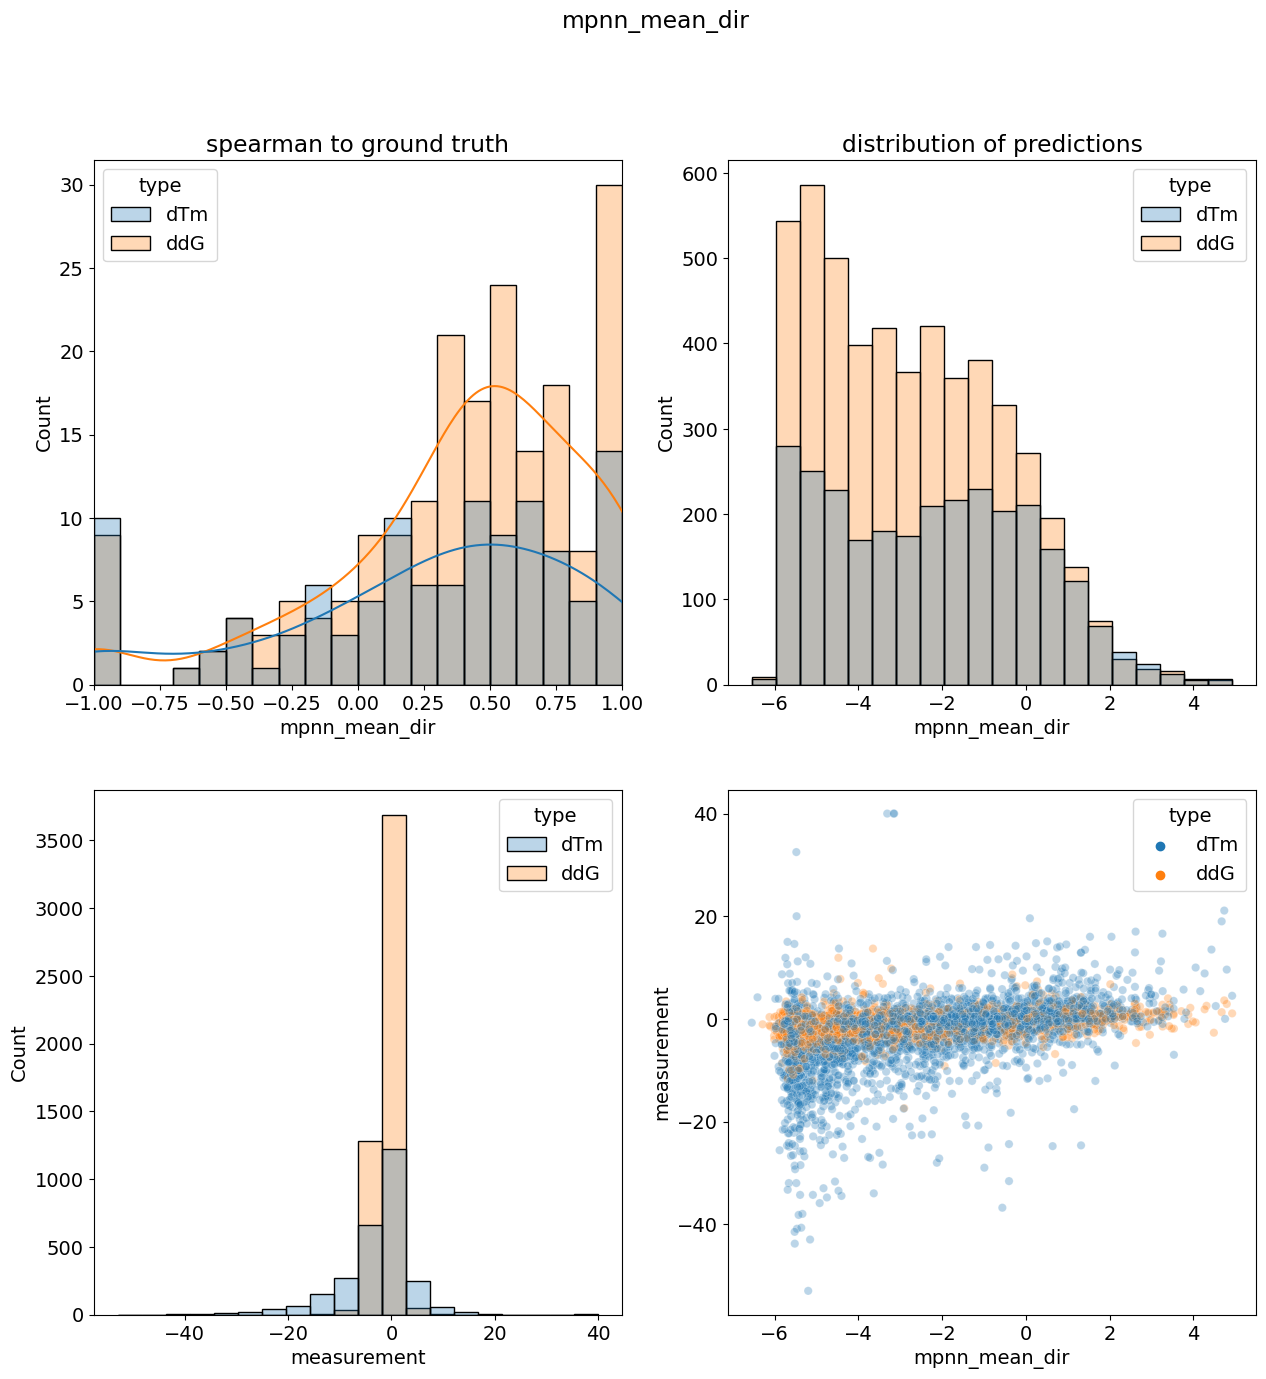

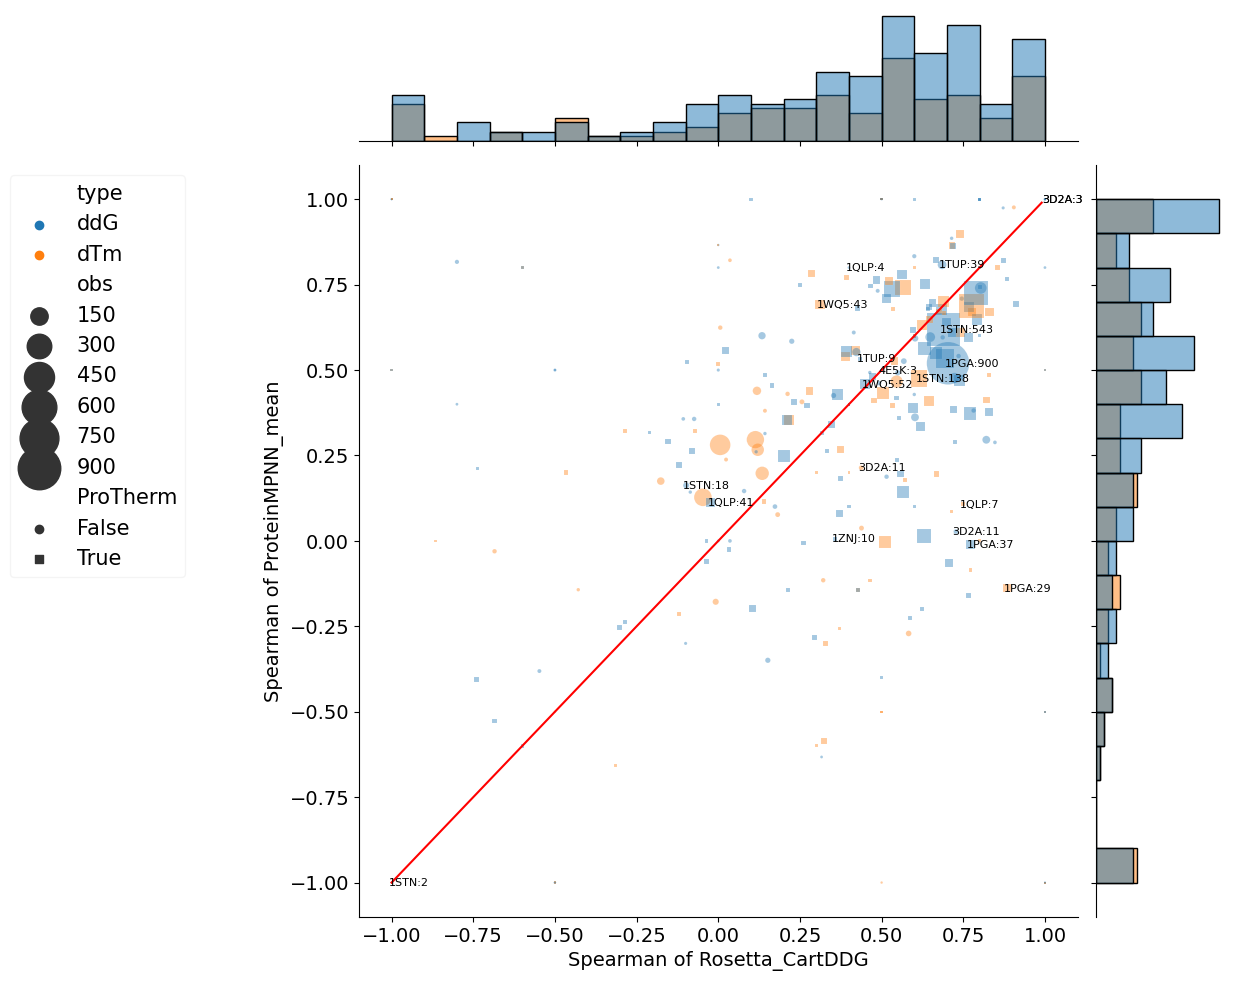

mpnn_mean_dir cartesian_ddg_dir
dTm n_total                      2796              2796
    ungrouped_spearman       0.509581          0.510162
    n_proteins                    131               131
    n_proteins_spearman           115               115
    avg_spearman             0.269391          0.318693
    weighted_spearman        0.335023          0.367637
    runtime (s)             85.684516         4592035.0
ddG n_total                      5065              5065
    ungrouped_spearman       0.446665           0.60121
    n_proteins                    176               176
    n_proteins_spearman           194               194
    avg_spearman             0.397766          0.365573
    weighted_spearman        0.409508          0.425745
    runtime (s)            124.716321         6795521.0

In [ ]:
# SUPPLEMENTARY FIGURE 1 (second figure generated)

db_corr = db_preds.join(db_measurements)

analysis_utils.correlations(db_corr, db_runtimes, stat='spearman', 
    score_name='mpnn_mean_dir', score_name_2='cartesian_ddg_dir', min_obs=1, group=True, plot=True, out=True, runtime=True)

In [ ]:
# SUPPLEMENTARY TABLE 3

tmp_ = analysis_utils.compute_stats(db_class, stats=['tp', 'fp', 'tn', 'fn', 'mean_t1s', 'auppc', 'aukxrc', 'mean_stabilization', 'net_stabilization'])
tmp_.to_csv('~/zs_suppl/fireprot_enrichment_all.csv')
tmp = tmp_.sort_values(['measurement', 'net_stabilization'], ascending=False).reset_index()

tmp['model'] = tmp['model'].map(remap_names_2)
tmp['measurement'] = tmp['measurement'].map({'ddG': 'ΔΔG', 'dTm': 'ΔTm'})
tmp.loc[tmp['model'].isin(['Gaussian noise', 'ΔΔG', 'ΔTm']), 'model_type'] = 'N/A'

remap_cols = {'tp': 'TP', 'fp': 'FP', 'tn': 'TN', 'fn': 'FN', 'mean_t1s': 'Mean Top-1 Score', 'auppc': 'AUPPC', 'aukxrc': 'AUKXRC', 'mean_stabilization': 'Mean Stabilization', 'net_stabilization': 'Net Stabilization'}
tmp = tmp.rename(remap_cols, axis=1)
tmp = tmp.drop('runtime', axis=1)
tmp = tmp.drop('class', axis=1)
tmp = tmp.drop([c for c in tmp.columns if '$' in c or 'x_recovery' in c], axis=1)
tmp = tmp.loc[tmp['model'].isin(['Rosetta_CartDDG', 'ProteinMPNN_mean', 'ProteinMPNN_30', 'ProteinMPNN_20', 'ESM-IF', 'MIF', 'ESM-IF(M)',
                            'ProteinMPNN_10', 'MIF-ST', 'KORPM', 'MSA-T_mean', 'MSA-T_1', 'Tranception', 'ESM-1V_mean', 'ESM-1V_2', 'Gaussian noise', 'ΔΔG', 'ΔTm'])]
tmp = tmp.dropna(subset='model').set_index(['measurement', 'model_type', 'model']).astype(float).round(3)
tmp = tmp[['TP', 'FP', 'TN', 'FN', 'AUPPC', 'AUKXRC', 'Mean Top-1 Score', 'Mean Stabilization', 'Net Stabilization']]
#tmp.to_csv('../../zs_suppl/fireprot_enrichment_select.csv')
tmp = tmp.drop([c for c in tmp.columns if '$' in c or 'x_recovery' in c], axis=1).reset_index()
tmp = tmp.loc[tmp['model'].isin(['Rosetta_CartDDG', 'ProteinMPNN_mean', 'ProteinMPNN_30', 'ProteinMPNN_20', 'ProteinMPNN_10', 'ESM-IF', 'MIF', 
    'ESM-IF(M)',  'MIF-ST', 'KORPM', 'MSA-T_mean', 'MSA-T_1', 'Tranception', 'ESM-1V_mean', 'ESM-1V_2', 'Gaussian noise', 'ΔΔG', 'ΔTm'])]
tmp = tmp.dropna(subset='model').set_index(['measurement', 'model_type', 'model']).astype(float).round(3)
tmp.to_csv('~/zs_suppl/fireprot_enrichment_select.csv')
tmp
# ~ 3 minutes

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

TP      FP      TN      FN  \
measurement model_type   model                                             
ΔΔG         structural   ProteinMPNN_mean  371.0   263.0  3409.0  1000.0   
                         Rosetta_CartDDG   577.0   457.0  3215.0   794.0   
                         ProteinMPNN_10    343.0   264.0  3408.0  1028.0   
                         ProteinMPNN_20    388.0   300.0  3372.0   983.0   
                         MIF-ST            239.0   190.0  3482.0  1132.0   
            evolutionary MSA-T_mean        128.0    85.0  3587.0  1243.0   
                         MSA-T_1           134.0   113.0  3559.0  1237.0   
            structural   ProteinMPNN_30    391.0   312.0  3360.0   980.0   
            evolutionary Tranception        86.0    85.0  3587.0  1285.0   
            structural   ESM-IF            284.0   228.0  3444.0  1087.0   
                         MIF               353.0   348.0  3324.0  1018.0   
                         ESM-IF(M)         282.0   240.0  3432.0  1089.0   
            evolutionary ESM-1V_mean       228.0   330.0  3342.0  1143.0   
            structural   KORPM             629.0   685.0  2987.0   742.0   
            evolutionary ESM-1V_2          224.0   329.0  3343.0  1147.0   
            N/A          Gaussian noise    674.0  1815.0  1857.0   697.0   
ΔTm         structural   ProteinMPNN_mean  339.0   209.0  1671.0   569.0   
                         ProteinMPNN_30    370.0   240.0  1640.0   538.0   
                         ProteinMPNN_20    353.0   225.0  1655.0   555.0   
                         ProteinMPNN_10    323.0   203.0  1677.0   585.0   
                         ESM-IF            238.0   154.0  1726.0   670.0   
                         ESM-IF(M)         244.0   155.0  1725.0   664.0   
                         MIF-ST            238.0   193.0  1687.0   670.0   
                         MIF               317.0   245.0  1635.0   591.0   
                         Rosetta_CartDDG   441.0   447.0  1433.0   467.0   
            evolutionary MSA-T_1           194.0   154.0  1726.0   714.0   
                         MSA-T_mean        193.0   153.0  1727.0   715.0   
                         Tranception       179.0   173.0  1707.0   729.0   
                         ESM-1V_mean       265.0   280.0  1600.0   643.0   
                         ESM-1V_2          252.0   283.0  1597.0   656.0   
            structural   KORPM             448.0   477.0  1403.0   460.0   
            N/A          Gaussian noise    442.0   911.0   969.0   466.0   

                                           AUPPC  AUKXRC  Mean Top-1 Score  \
measurement model_type   model                                               
ΔΔG         structural   ProteinMPNN_mean  0.424   0.393             0.036   
                         Rosetta_CartDDG   0.417   0.390            -0.030   
                         ProteinMPNN_10    0.415   0.385            -0.017   
                         ProteinMPNN_20    0.421   0.390             0.063   
                         MIF-ST            0.383   0.362            -0.015   
            evolutionary MSA-T_mean        0.349   0.335            -0.077   
                         MSA-T_1           0.346   0.333            -0.123   
            structural   ProteinMPNN_30    0.417   0.387            -0.042   
            evolutionary Tranception       0.333   0.324            -0.252   
            structural   ESM-IF            0.404   0.378             0.022   
                         MIF               0.403   0.376             0.077   
                         ESM-IF(M)         0.402   0.377            -0.050   
            evolutionary ESM-1V_mean       0.342   0.331            -0.274   
            structural   KORPM             0.387   0.366            -0.122   
            evolutionary ESM-1V_2          0.338   0.328            -0.285   
            N/A          Gaussian noise    0.272   0.284            -0.590   
ΔTm         structural   ProteinMPNN_mean  0.444   0.386 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/10 [00:00<?, ?it/s]

Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/10 [00:00<?, ?it/s]

Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Couldn't compute AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
ΔΔG > 0: 1

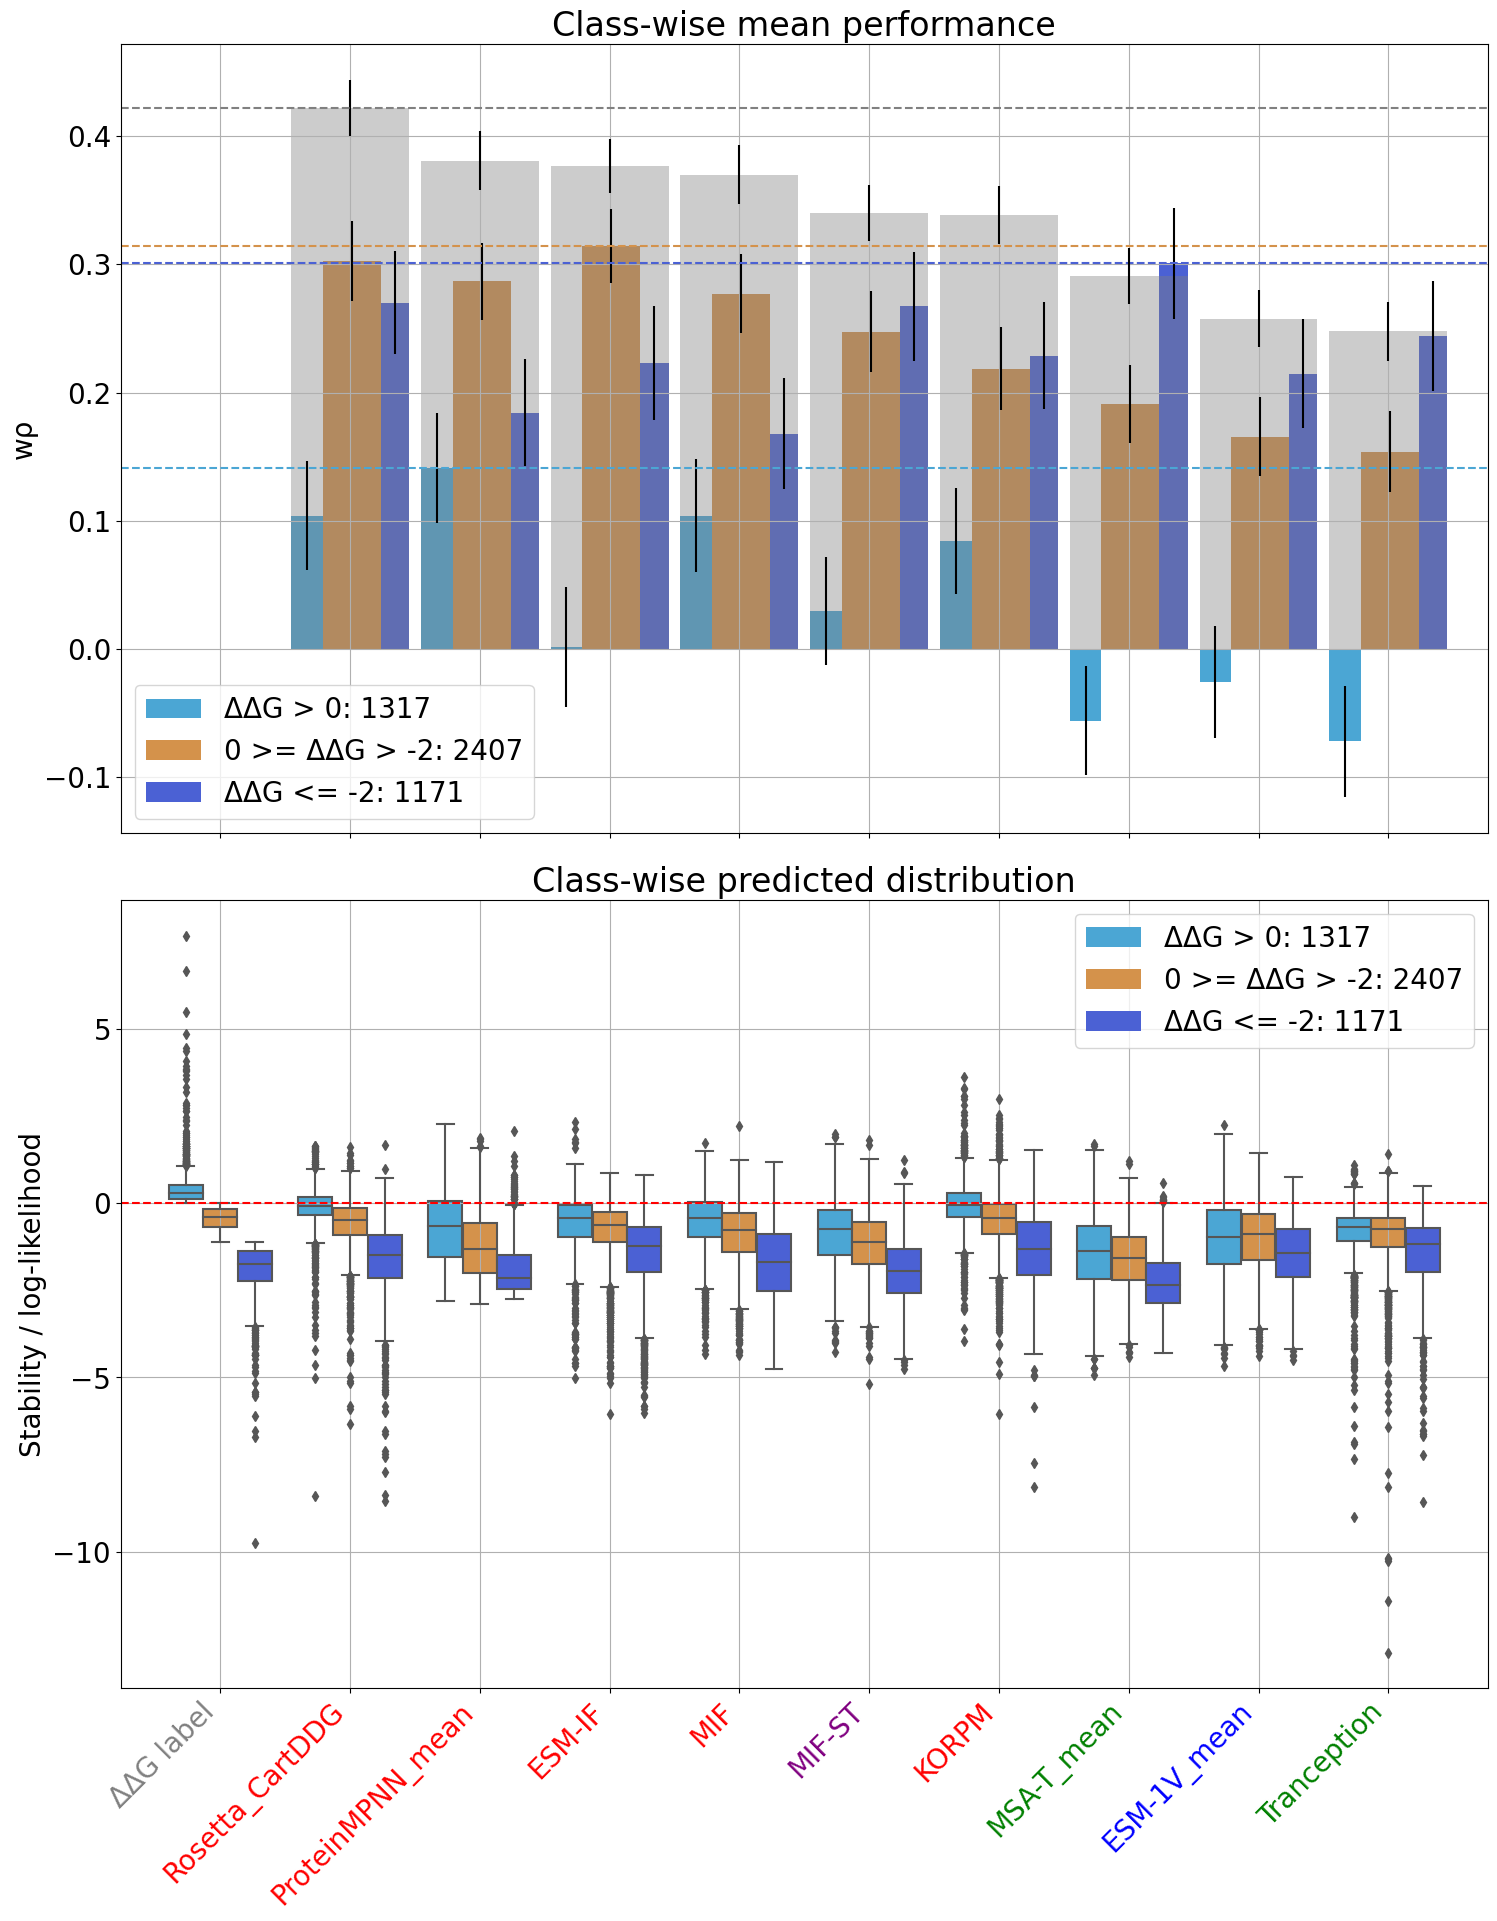

In [ ]:
# Figure 1 a + b

custom_colors = {'cartesian_ddg_dir': 'red',
                 'korpm_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 'msa_transformer_mean_dir': 'green',
                 'tranception_dir': 'green',
                 #'esmif_monomer_dir': 'red',
                 'esmif_multimer_dir': 'red',
                 #'esmif_monomer_masked_dir': 'red',
                 'mpnn_mean_dir': 'red',
                 #'mpnn_10_00_dir': 'red',
                 #'mpnn_20_00_dir': 'red',
                 #'mpnn_30_03_dir': 'red',
                 #'mpnn_30_00_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'purple',
                 'ddG_dir': 'grey'}

db_complete = db_preds.join(db_measurements, how='left').drop(['ProTherm', 'FireProt', 'is_curated', 'ThermoFluor', 'dTm'], axis=1).join(db_feats_2, how='left').dropna(subset='korpm_dir').dropna(subset='msa_transformer_mean_dir')#.dropna(subset='esmif_multimer_dir')
db_complete['ddG_dir'] = db_complete['ddG']
db_complete['ΔΔG'] = db_complete['ddG']
#db_complete = db_complete.loc[~db_complete['ProTherm'].astype(bool)]

current_feats = ['ΔΔG', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats]]
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'ΔΔG', 
                        split_col_2 = None, 
                        threshold_1 = 0, 
                        threshold_2 = -2, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        custom_colors = custom_colors
                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

delta_vol > 1: 1058
1 >= delta_vol > -1: 1310
delta_vol <= -1: 2524
['ddG_dir', 'cartesian_ddg_dir', 'mpnn_mean_dir', 'esmif_multimer_dir', 'mif_dir', 'mifst_dir', 'korpm_dir', 'msa_transformer_mean_dir', 'esm1v_mean_dir', 'tranception_dir']
class
1 >= delta_vol > -1    1310
delta_vol <= -1        2524
delta_vol > 1          1058
Name: n, dtype: int64


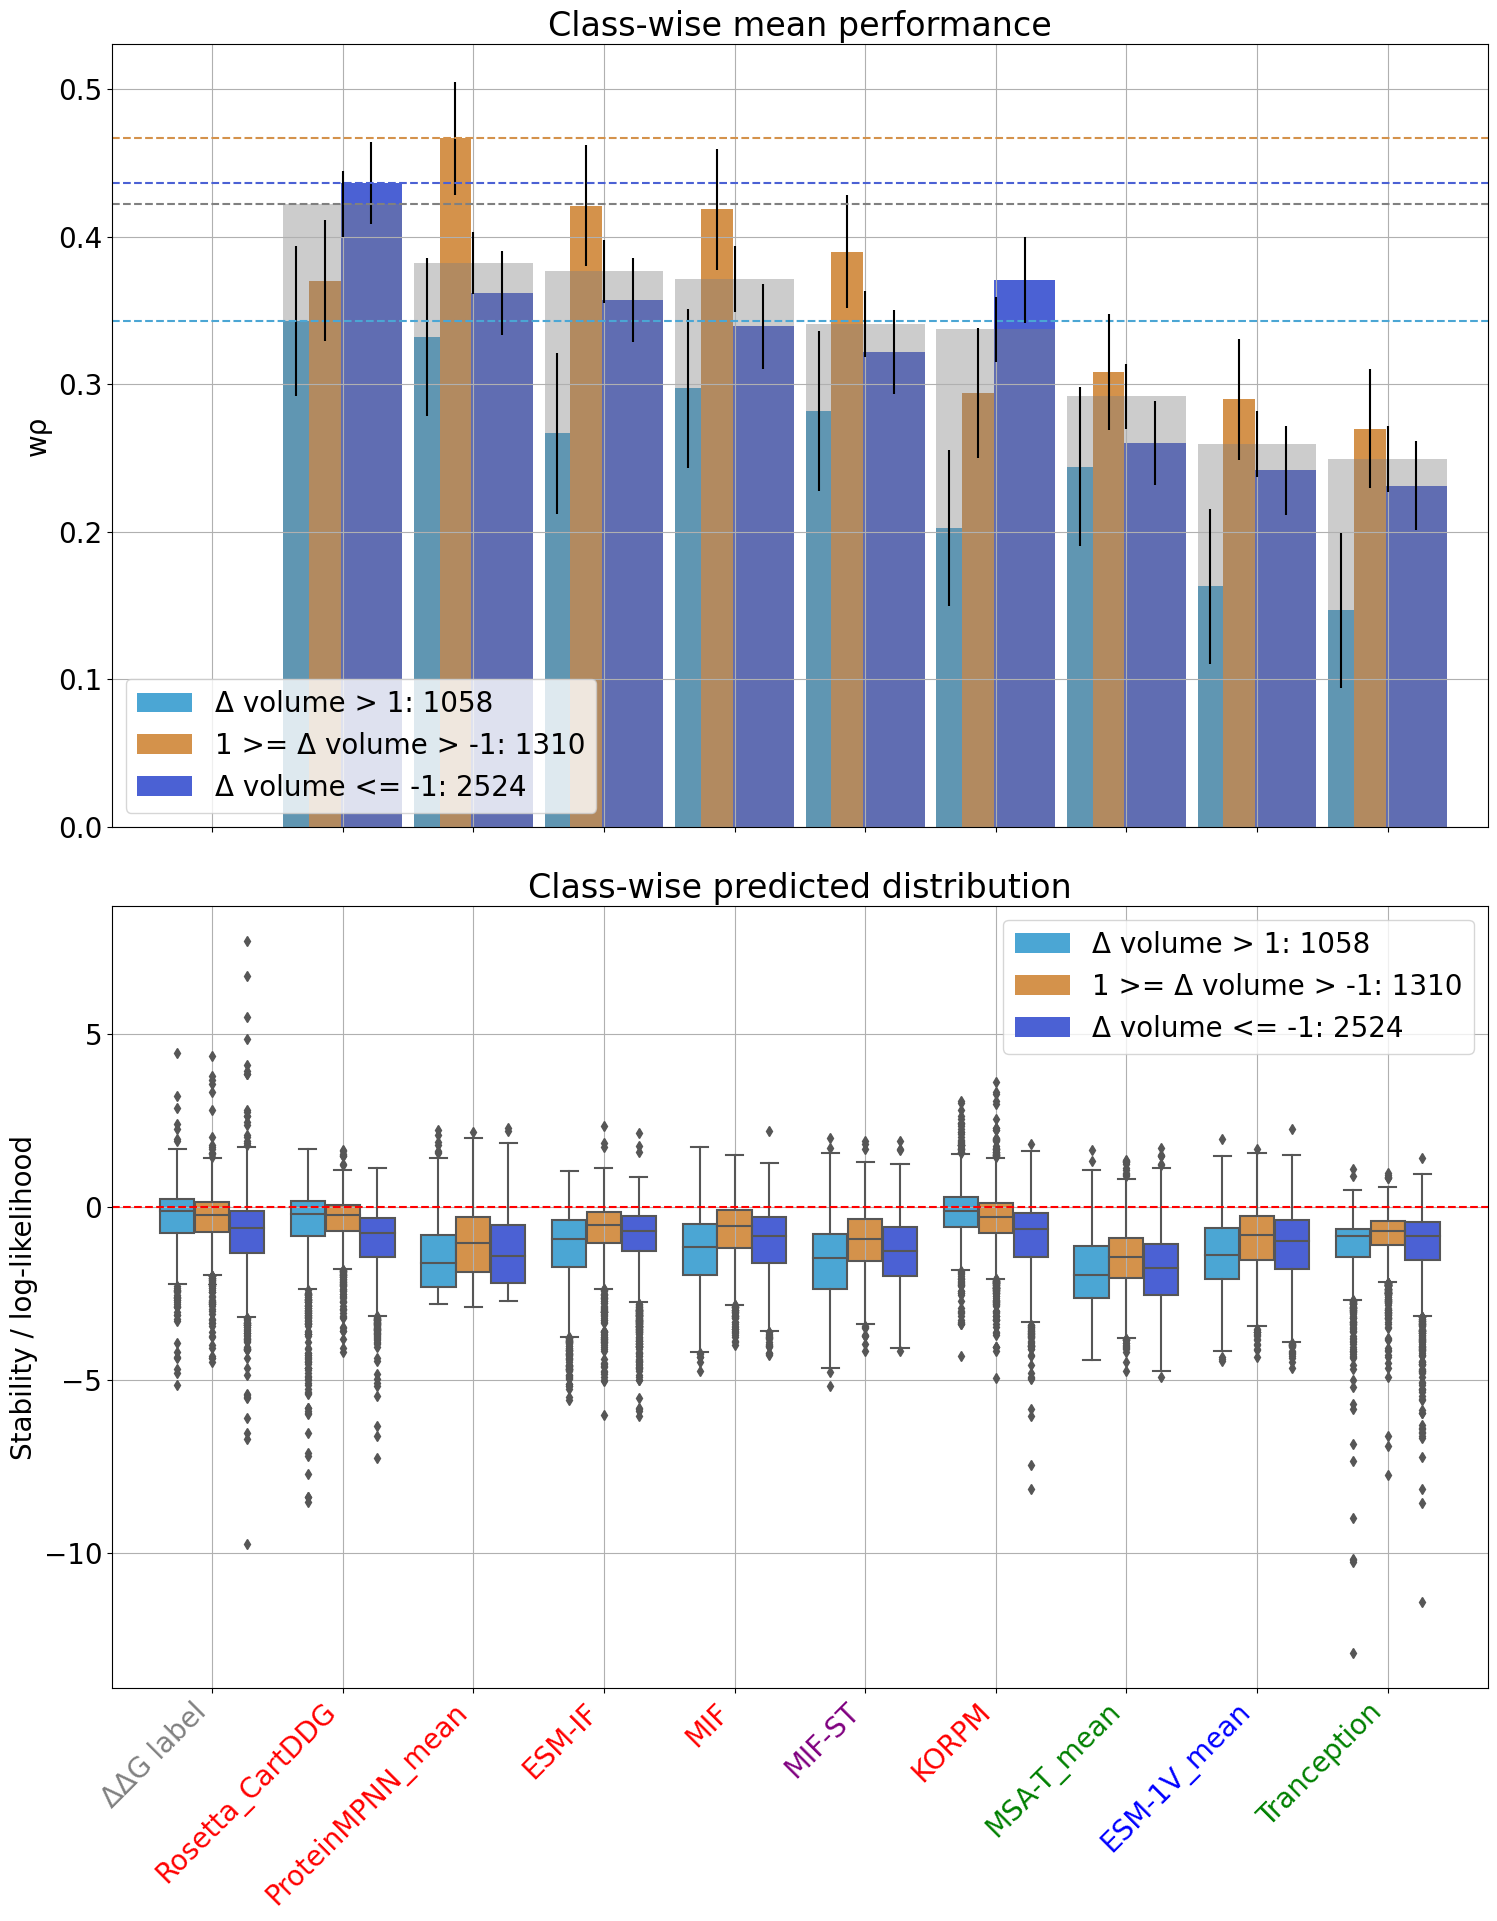

In [ ]:
# Figure 1 c + d

current_feats = ['delta_vol', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats]]
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'delta_vol', 
                        split_col_2 = None, 
                        threshold_1 = 1, 
                        threshold_2 = -1, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        custom_colors = custom_colors
                        )

KeyError: "['cartesian_ddg_dir', 'korpm_dir', 'esm1v_mean_dir', 'msa_transformer_mean_dir', 'tranception_dir', 'esmif_multimer_dir', 'mpnn_mean_dir', 'mif_dir', 'mifst_dir'] not in index"

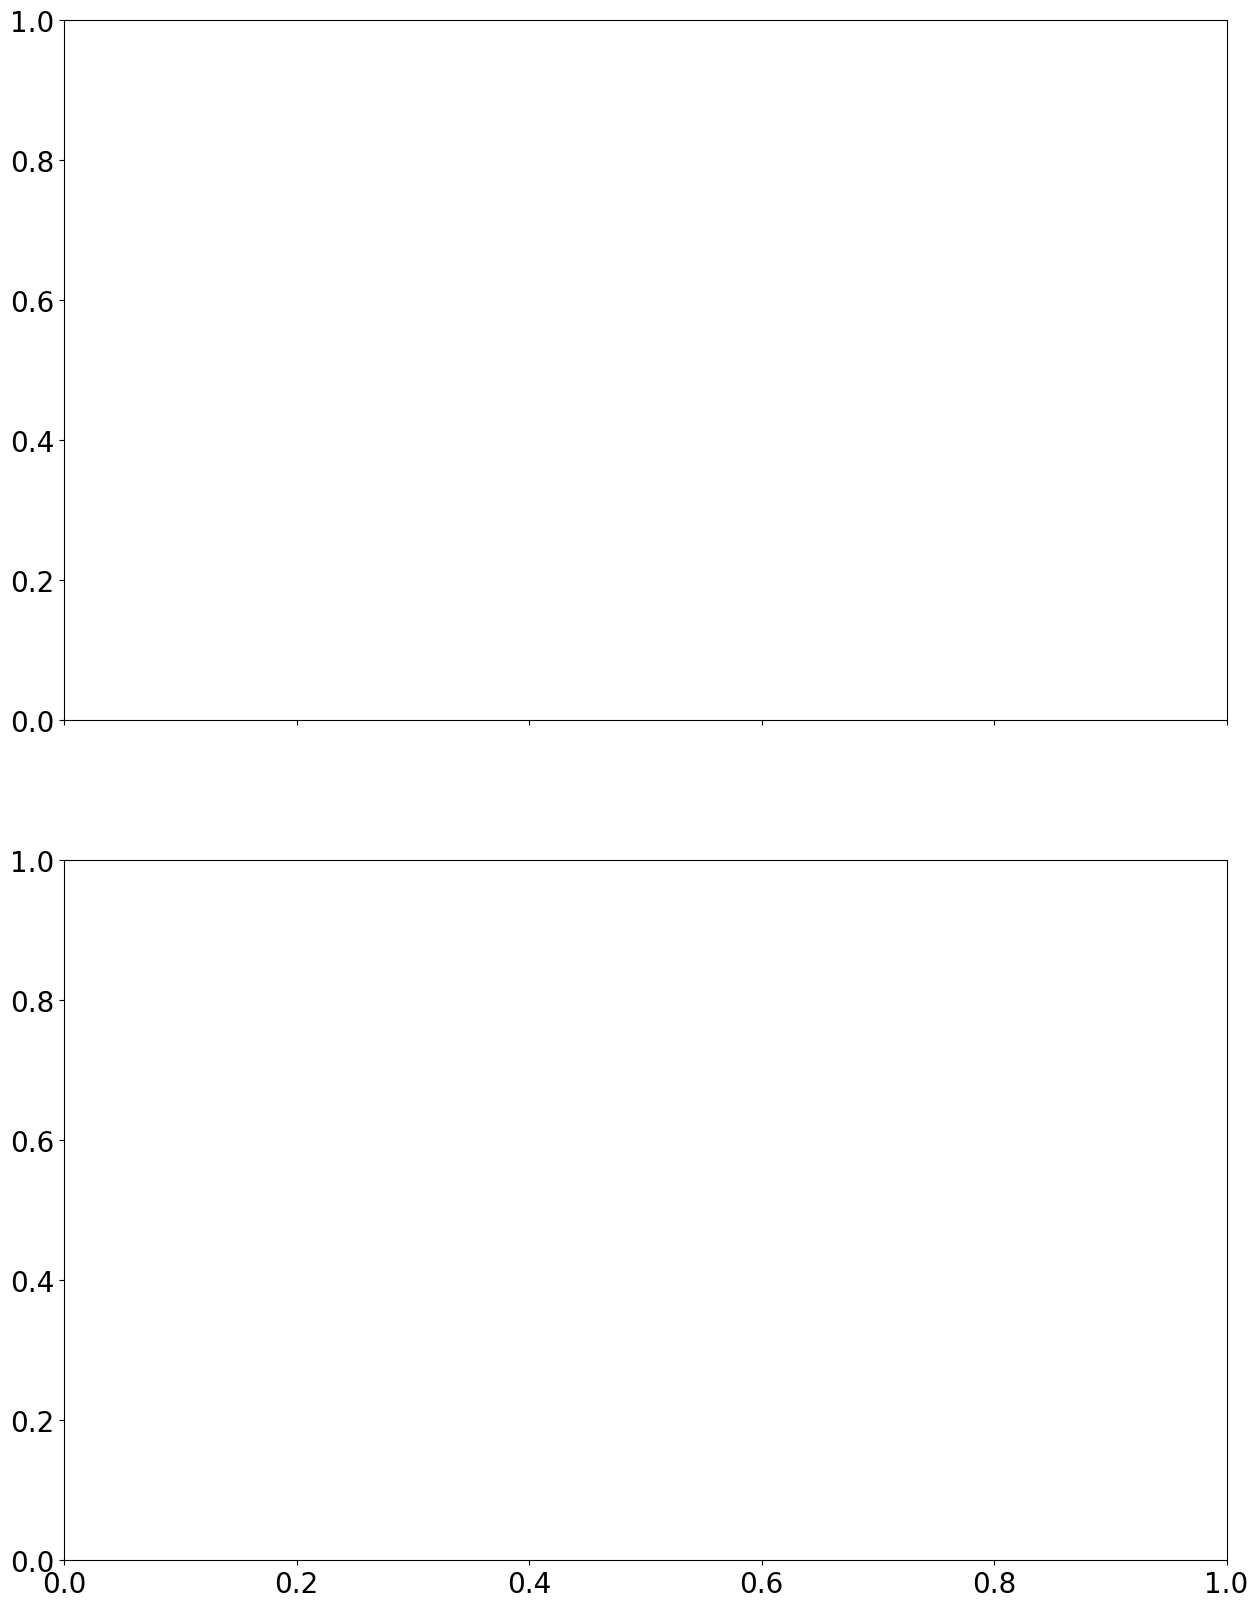

In [ ]:
# Supplementary Figure 2

current_feats = ['delta_kdh', 'rel_ASA', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats]]
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'delta_kdh', 
                        split_col_2 = 'rel_ASA', 
                        threshold_1 = 0, 
                        threshold_2 = 0.1, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        custom_colors = custom_colors
                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

conservation > 80: 737
conservation <= 80: 4224
['ddG_dir', 'cartesian_ddg_dir', 'mpnn_mean_dir', 'esmif_multimer_dir', 'mif_dir', 'mifst_dir', 'korpm_dir', 'msa_transformer_mean_dir', 'esm1v_mean_dir', 'tranception_dir']
class
conservation <= 80    4224
conservation > 80      737
Name: n, dtype: int64


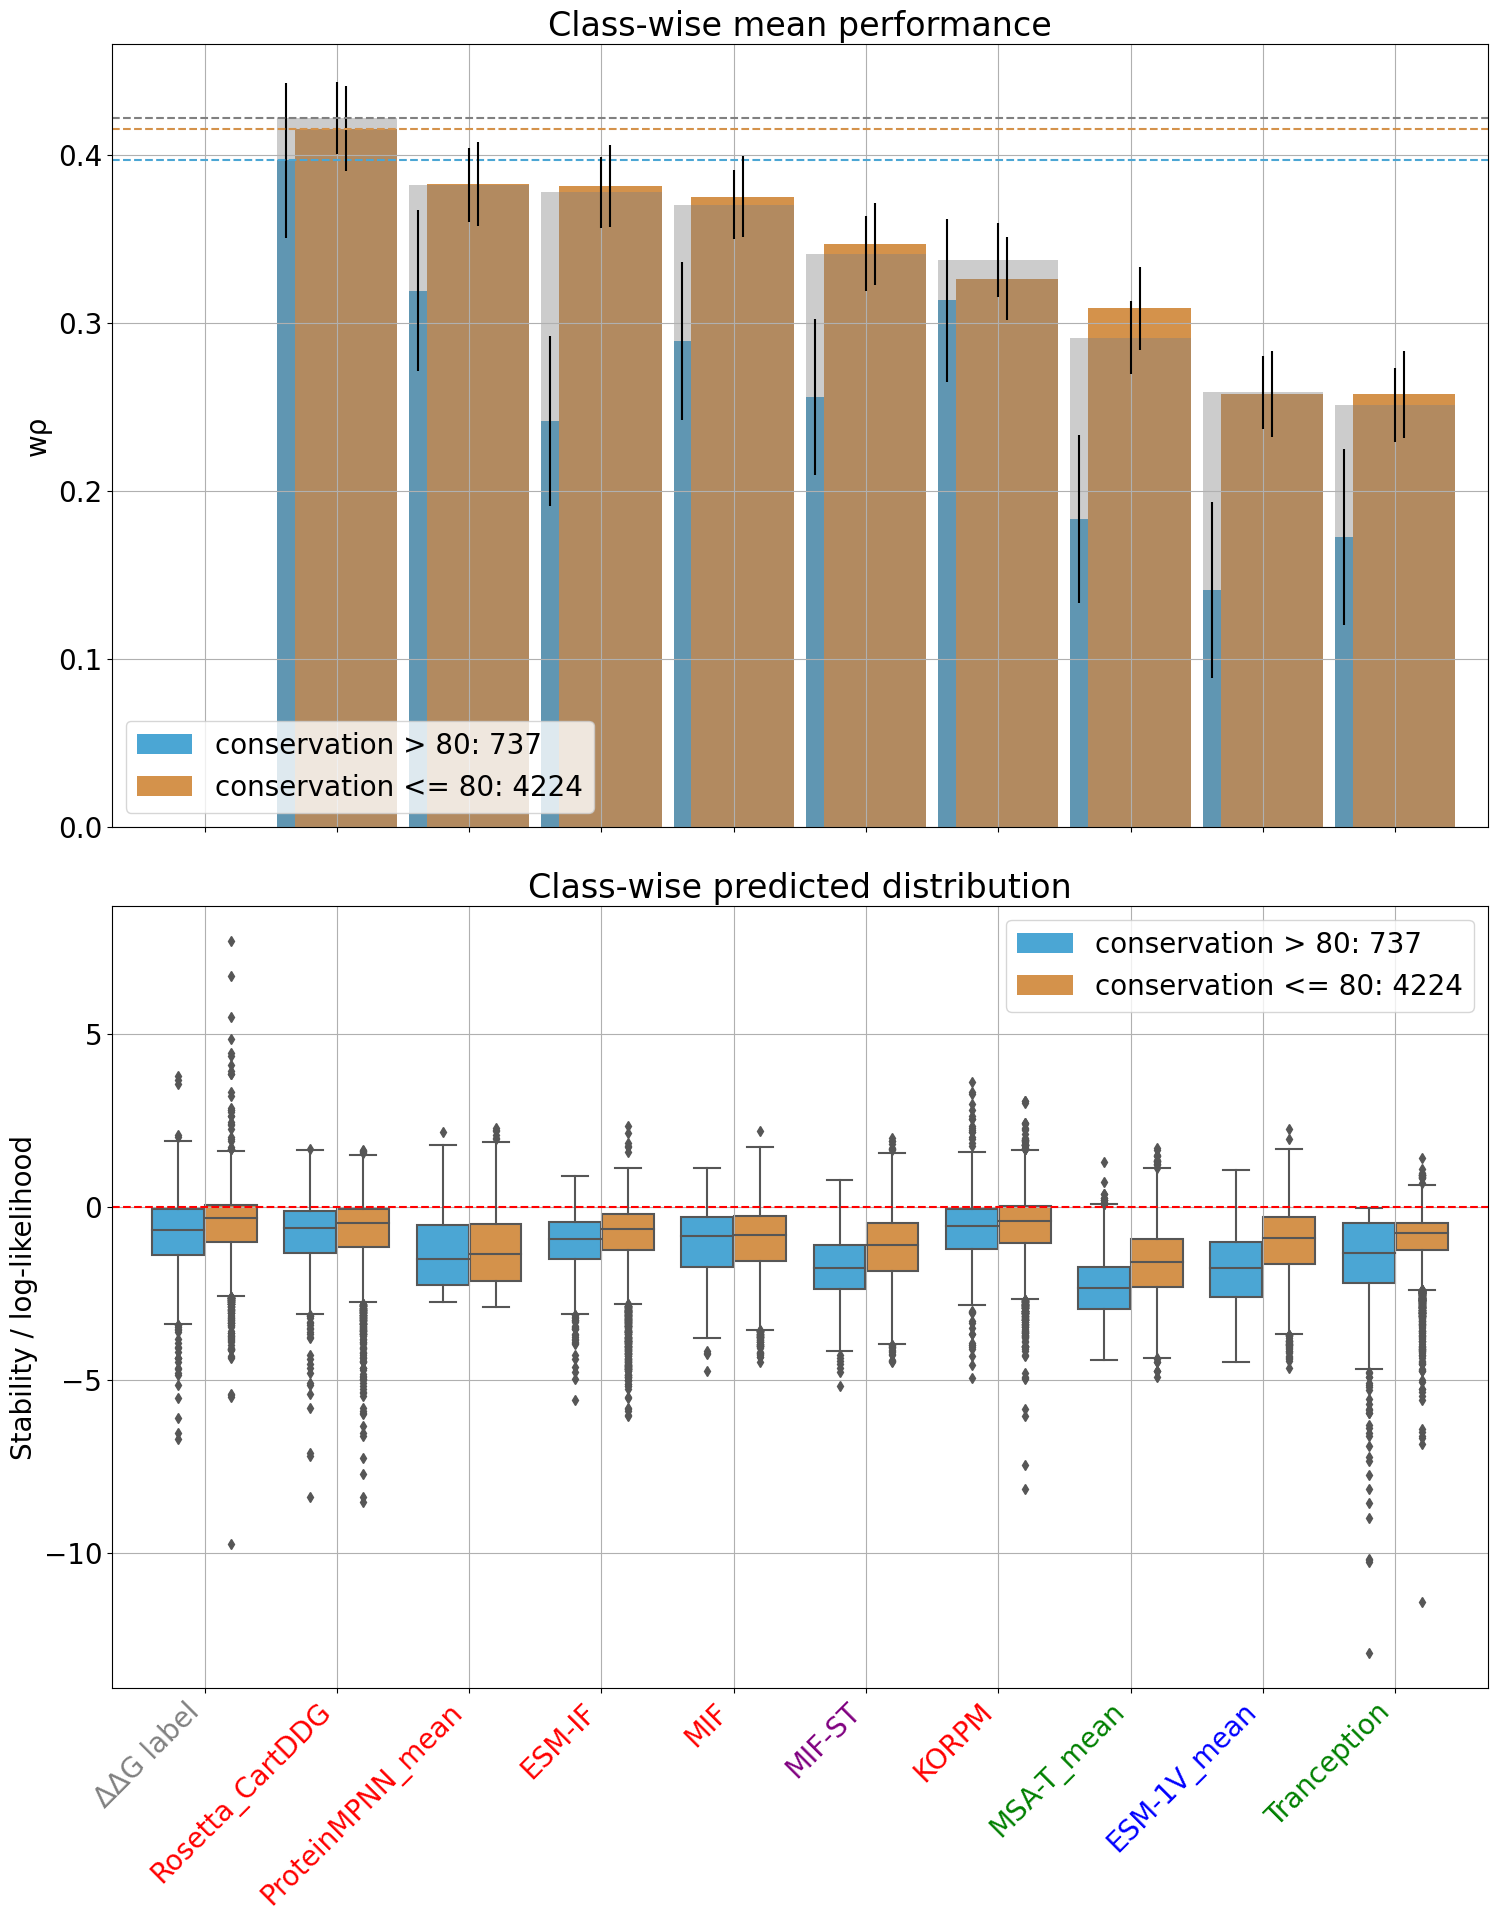

In [ ]:
# Supplementary Figure 3

current_feats = ['conservation', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats]]
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'conservation', 
                        split_col_2 = None, 
                        threshold_1 = 80, 
                        threshold_2 = None, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        custom_colors = custom_colors
                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

multimer > 1: 1099
multimer <= 1: 3901
['ddG_dir', 'cartesian_ddg_dir', 'mpnn_mean_dir', 'esmif_multimer_dir', 'mif_dir', 'mifst_dir', 'korpm_dir', 'msa_transformer_mean_dir', 'esm1v_mean_dir', 'tranception_dir']
class
multimer <= 1    3901
multimer > 1     1099
Name: n, dtype: int64


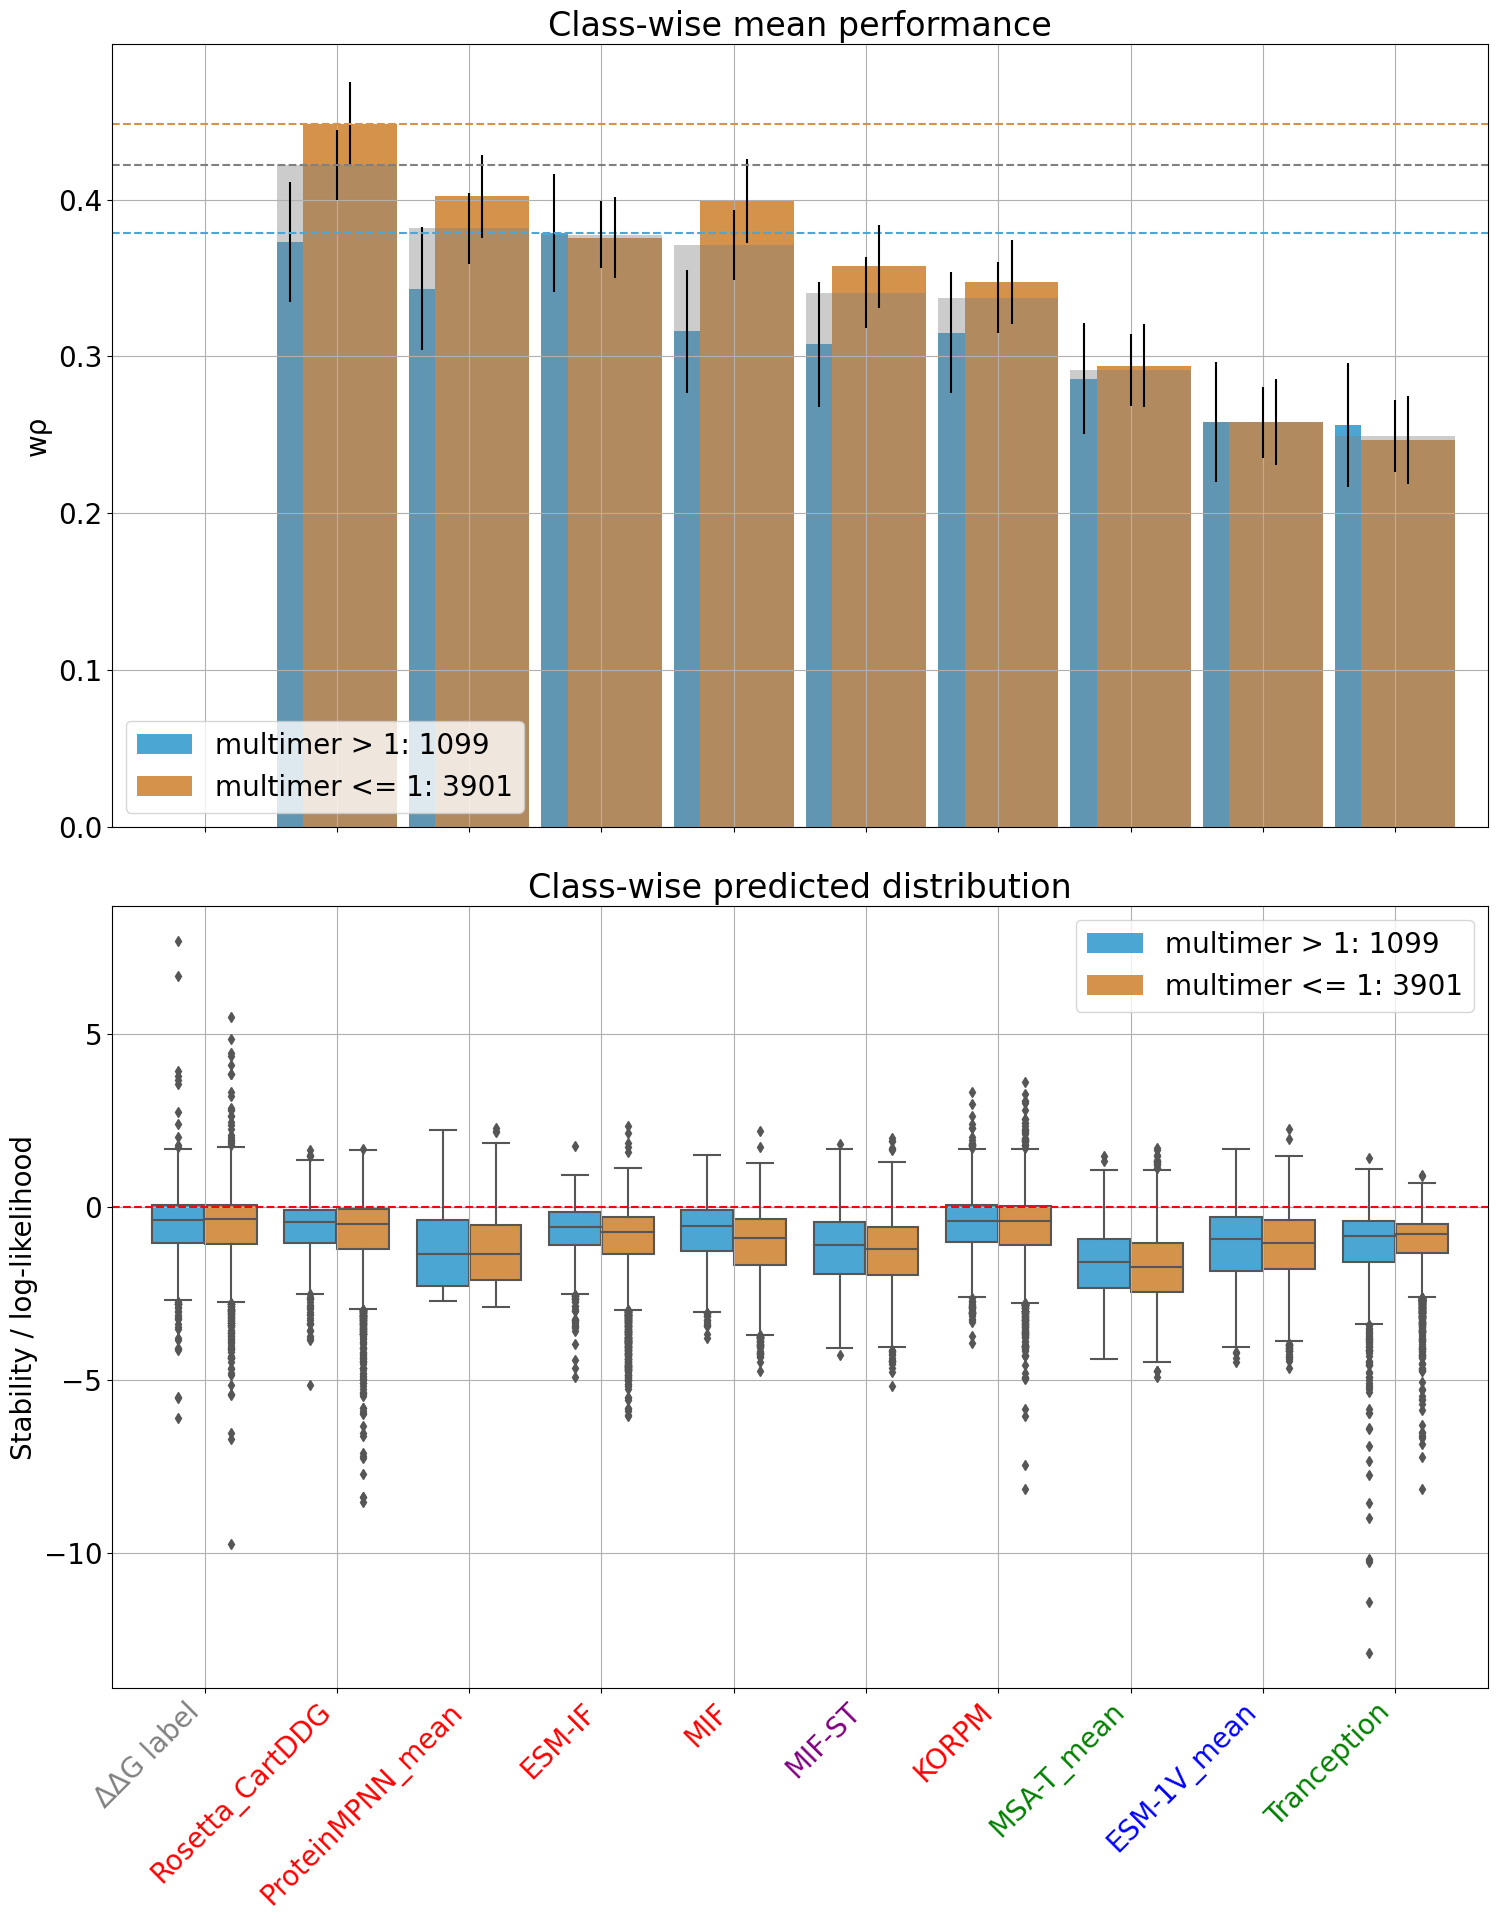

In [ ]:
# Supplementary Figure 4

current_feats = ['multimer', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats]]
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'multimer', 
                        split_col_2 = None, 
                        threshold_1 = 1, 
                        threshold_2 = None, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        custom_colors = custom_colors
                        )

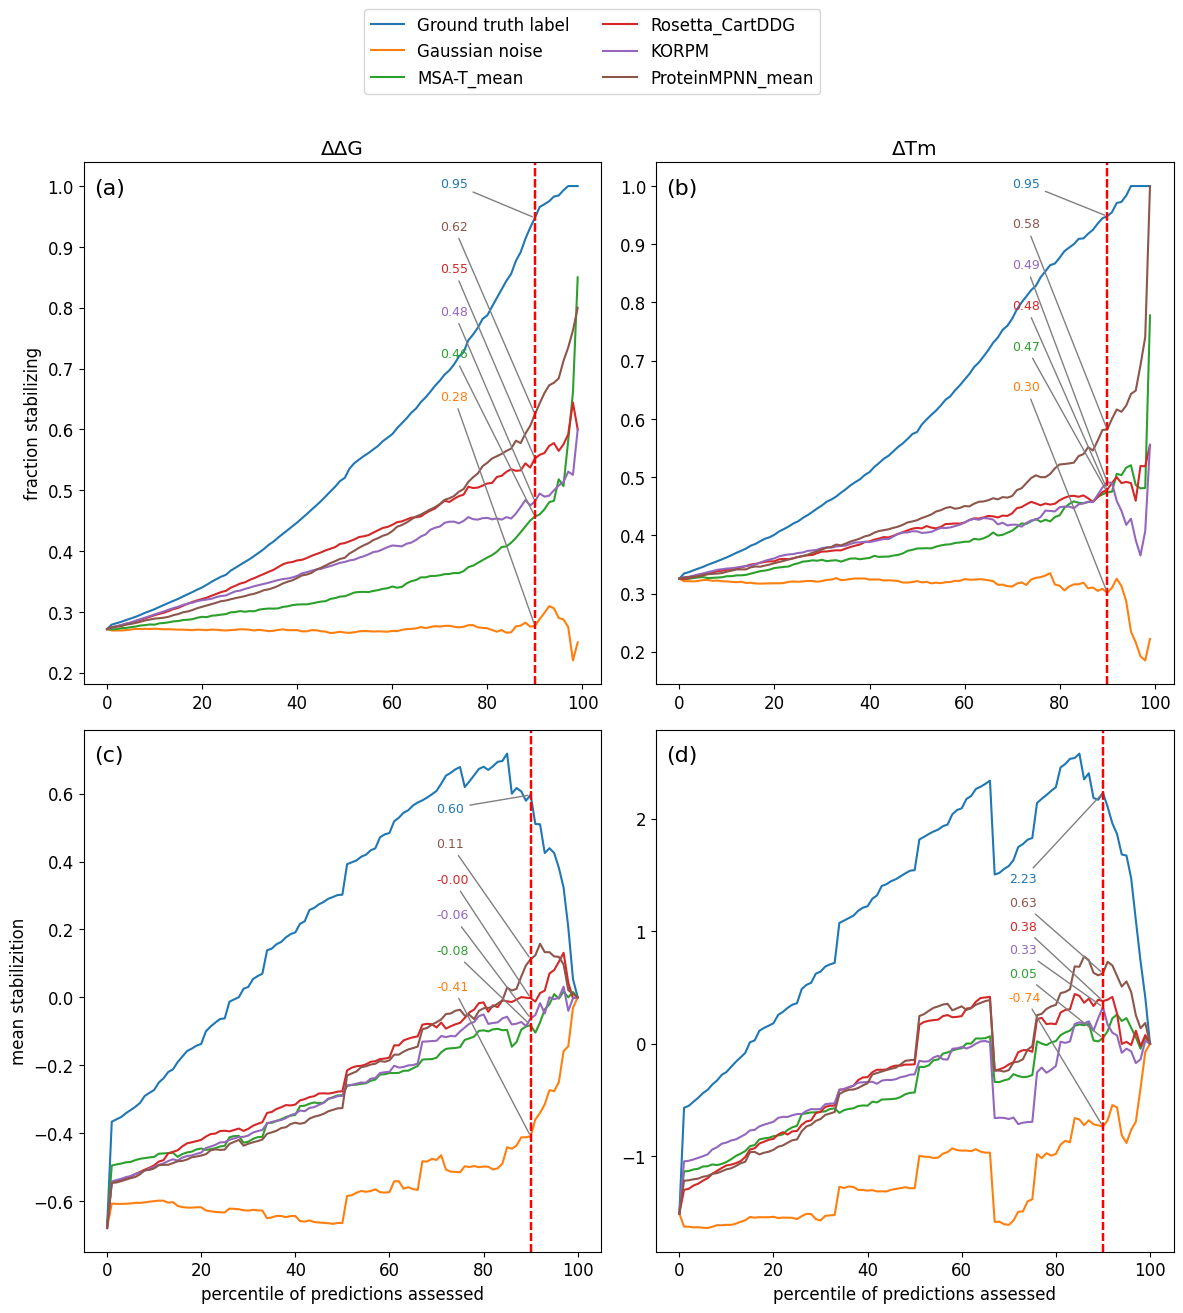

In [ ]:
# FIGURE 2

# rcv defined when generating tables above
analysis_utils.recovery_curves(rcv, ['mpnn_mean_dir', 'cartesian_ddg_dir', 'korpm_dir', 'msa_transformer_mean_dir', 'ddG_dir', 'dTm_dir', 'random_dir'], spacing=0.07) #'mif_dir', 'esmif_multimer_full_dir',

In [ ]:
# generate ensembles for Model Complementarity section

models = ['esmif_multimer_dir', 'esmif_monomer_dir', 'mif_dir', 'mifst_dir', 
          'mpnn_10_00_dir', 'mpnn_20_00_dir', 'mpnn_30_00_dir', 'mpnn_mean_dir', 
          'tranception_dir', 'esm1v_mean_dir', 'esm1v_median_dir', 
          'msa_transformer_mean_dir', 'msa_transformer_median_dir', 
          'korpm_dir', 'cartesian_ddg_dir', 
          'rel_ASA_dir', 'delta_kdh_dir', 'delta_vol_dir', 'delta_chg_dir'
          ]

zs_feats = ['rel_ASA', 'delta_kdh', 'delta_vol', 'delta_chg']

db_summ = db_preds.join(db_measurements).drop('code', axis=1)
print(len(db_summ))
#db_summ = db_summ.loc[~db_summ['ProTherm'].astype(bool)]
#db_summ = db_summ.loc[db_summ['is_curated'].astype(bool)]
db_summ = db_summ.dropna(subset='korpm_dir').dropna(subset='msa_transformer_mean_dir')
print(len(db_summ))
db_summ['ddG_dir'] = db_summ['ddG']
db_summ['dTm_dir'] = db_summ['dTm']
db_summ['random_dir'] = np.random.normal(loc=0, size=len(db_summ))

dfm = db_summ.join(db_feats_2[zs_feats].drop_duplicates(), how='left')
dfm['code'] = dfm.index.str[:4]
ren = dict(zip(zs_feats, [f+'_dir' for f in zs_feats]))
dfm = dfm.rename(ren, axis=1)
dfm = dfm.drop(['is_curated'], axis=1)
dfr = db_runtimes.copy(deep=True)
dfr['code'] = dfr.index.str[:4]
dfr[['runtime_' + r for r in ['rel_ASA_dir', 'delta_kdh_dir', 'delta_vol_dir', 'delta_chg_dir']]] = 0

weights = [1, 0.5, 0.2] #, -0.2] # could include -0.2 to allow for subtracting models
weights2 = [] # fill in weights to test 3-model ensembles
#weights2 = [0.8, 0.3]

all_cols = []

tmp_preds = []
tmp_runtimes = []
for model1 in models:
    for model2 in models:
        if model1 != model2:
            for weight in weights:
                tmp_preds.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                #tmp_preds.append(pd.Series((dfm[model1]-dfm[model1].min())/dfm[model1].max() + (dfm[model2]-dfm[model2].min())/dfm[model1].max() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                tmp_runtimes.append(pd.Series(dfr['runtime_'+model1] + dfr['runtime_'+model2], name=f'runtime_'+all_cols[-1]))
                for model3 in models:
                    #if (model1.split('_')[0] != model3.split('_')[0]) and (model2.split('_')[0] != model3.split('_')[0]):
                        for weight2 in weights2:
                            tmp_preds.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight + dfm[model3]/dfm[model3].std() * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                            #tmp_preds.append(pd.Series((dfm[model1]-dfm[model1].min())/dfm[model1].max() + (dfm[model2]-dfm[model2].min())/dfm[model2].max() * weight + (dfm[model3]-dfm[model3].min())/dfm[model3].max() * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')
                            tmp_runtimes.append(pd.Series(dfr['runtime_'+model1] + dfr['runtime_'+model2] + dfr['runtime_'+model3], name='runtime_'+all_cols[-1]))

print('concatenating')
dfm = pd.concat([dfm] + tmp_preds, axis=1)
dfr = pd.concat([dfr] + tmp_runtimes, axis=1)
#print('saving...')
#dfm.to_csv('~/zs_suppl/preds_ensemble_fireprot_3_models.csv')
print('joining...')
dfm = dfm.join(dfr.drop('code', axis=1))

6313
6283
concatenating
joining...


In [ ]:
def get_summary_df(db_complete, cols=None, class_stats=(), saveloc='../../zeroshot suppl/fireprot_summary.csv', overwrite=False):

    if not overwrite:
        assert not os.path.exists(saveloc)
    if cols is None:
        cols = db_complete.columns
        for extra in ['code', 'ProTherm', 'FireProt', 'is_curated', 'ThermoFluor']:
            if extra in cols:
                cols = cols.drop(extra)

    df_summ = analysis_utils.compute_stats(db_complete[cols], stats=class_stats).reset_index().set_index(['measurement', 'model'])
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1)
    df_summ = df_summ.set_index(['measurement', 'model_type', 'model', 'class'])

    df_summ.to_csv(saveloc)
    return df_summ

In [ ]:
# compute all statistics on the combined set (already done, takes ~12 hours)
d1 = get_summary_df(dfm, saveloc=os.path.join(path, 'data', 'fireprot_2_models_3_weights.csv'), overwrite=True)
#d1 = pd.read_csv('~/zs_suppl/ensemble_fireprot_2_models_3_weights.csv').set_index(['measurement', 'model_type', 'model', 'class'])
d1.xs('ddG').sort_values('weighted_ndcg', ascending=False).iloc[:20, 13:]

auroc     auprc  \
model_type model                                    class                       
NaN        ddG_dir                                  NaN    1.000000  1.000000   
           dTm_dir                                  NaN    0.946825  0.856855   
structural cartesian_ddg_dir + mpnn_mean_dir * 0.5  NaN    0.787056  0.567737   
           mpnn_mean_dir + cartesian_ddg_dir * 1    NaN    0.769711  0.554291   
           cartesian_ddg_dir + mpnn_mean_dir * 1    NaN    0.769711  0.554291   
           cartesian_ddg_dir + mpnn_20_00_dir * 0.5 NaN    0.787447  0.568164   
           mpnn_20_00_dir + cartesian_ddg_dir * 1   NaN    0.769597  0.552941   
           cartesian_ddg_dir + mpnn_20_00_dir * 1   NaN    0.769597  0.552941   
           korpm_dir + mpnn_20_00_dir * 1           NaN    0.756120  0.522233   
           mpnn_20_00_dir + korpm_dir * 1           NaN    0.756120  0.522233   
           mpnn_mean_dir + cartesian_ddg_dir * 0.5  NaN    0.748461  0.531586   
           mpnn_mean_dir + korpm_dir * 1            NaN    0.756502  0.524535   
           korpm_dir + mpnn_mean_dir * 1            NaN    0.756502  0.524535   
           cartesian_ddg_dir + mpnn_10_00_dir * 0.5 NaN    0.786065  0.565138   
           cartesian_ddg_dir + mpnn_30_00_dir * 0.5 NaN    0.783536  0.560044   
           mpnn_20_00_dir + cartesian_ddg_dir * 0.5 NaN    0.747944  0.527543   
           mpnn_30_00_dir + cartesian_ddg_dir * 1   NaN    0.764328  0.546133   
           cartesian_ddg_dir + mpnn_30_00_dir * 1   NaN    0.764328  0.546133   
           mpnn_20_00_dir + korpm_dir * 0.5         NaN    0.741926  0.512924   
           mpnn_10_00_dir + cartesian_ddg_dir * 1   NaN    0.767721  0.546413   

                                                           n_stable  \
model_type model                                    class             
NaN        ddG_dir                                  NaN      1371.0   
           dTm_dir                                  NaN       428.0   
structural cartesian_ddg_dir + mpnn_mean_dir * 0.5  NaN      1371.0   
           mpnn_mean_dir + cartesian_ddg_dir * 1    NaN      1371.0   
           cartesian_ddg_dir + mpnn_mean_dir * 1    NaN      1371.0   
           cartesian_ddg_dir + mpnn_20_00_dir * 0.5 NaN      1371.0   
           mpnn_20_00_dir + cartesian_ddg_dir * 1   NaN      1371.0   
           cartesian_ddg_dir + mpnn_20_00_dir * 1   NaN      1371.0   
           korpm_dir + mpnn_20_00_dir * 1           NaN      1371.0   
           mpnn_20_00_dir + korpm_dir * 1           NaN      1371.0   
           mpnn_mean_dir + cartesian_ddg_dir * 0.5  NaN      1371.0   
           mpnn_mean_dir + korpm_dir * 1            NaN      1371.0   
           korpm_dir + mpnn_mean_dir * 1            NaN      1371.0   
           cartesian_ddg_dir + mpnn_10_00_dir * 0.5 NaN      1371.0   
           cartesian_ddg_dir + mpnn_30_00_dir * 0.5 NaN      1371.0   
           mpnn_20_00_dir + cartesian_ddg_dir * 0.5 NaN      1371.0   
           mpnn_30_00_dir + cartesian_ddg_dir * 1   NaN      1371.0   
           cartesian_ddg_dir + mpnn_30_00_dir * 1   NaN      1371.0   
           mpnn_20_00_dir + korpm_dir * 0.5         NaN      1371.0   
           mpnn_10_00_dir + cartesian_ddg_dir * 1   NaN      1371.0   

                                                           precision@k  \
model_type model                                    class                
NaN        ddG_dir                                  NaN       1.000000   
           dTm_dir                                  NaN       0.857477   
structural cartesian_ddg_dir + mpnn_mean_dir * 0.5  NaN       0.536105   
           mpnn_mean_dir + cartesian_ddg_dir * 1    NaN       0.517870   
           cartesian_ddg_dir + mpnn_mean_dir * 1    NaN       0.517870   
           cartesian_ddg_dir + mpnn_20_00_dir * 0.5 NaN       0.544128   
           mpnn_20_00_dir + cartesian_ddg_dir * 1   NaN       0.522976   
           cartesian_ddg_dir + mpnn_20_00_dir * 1 

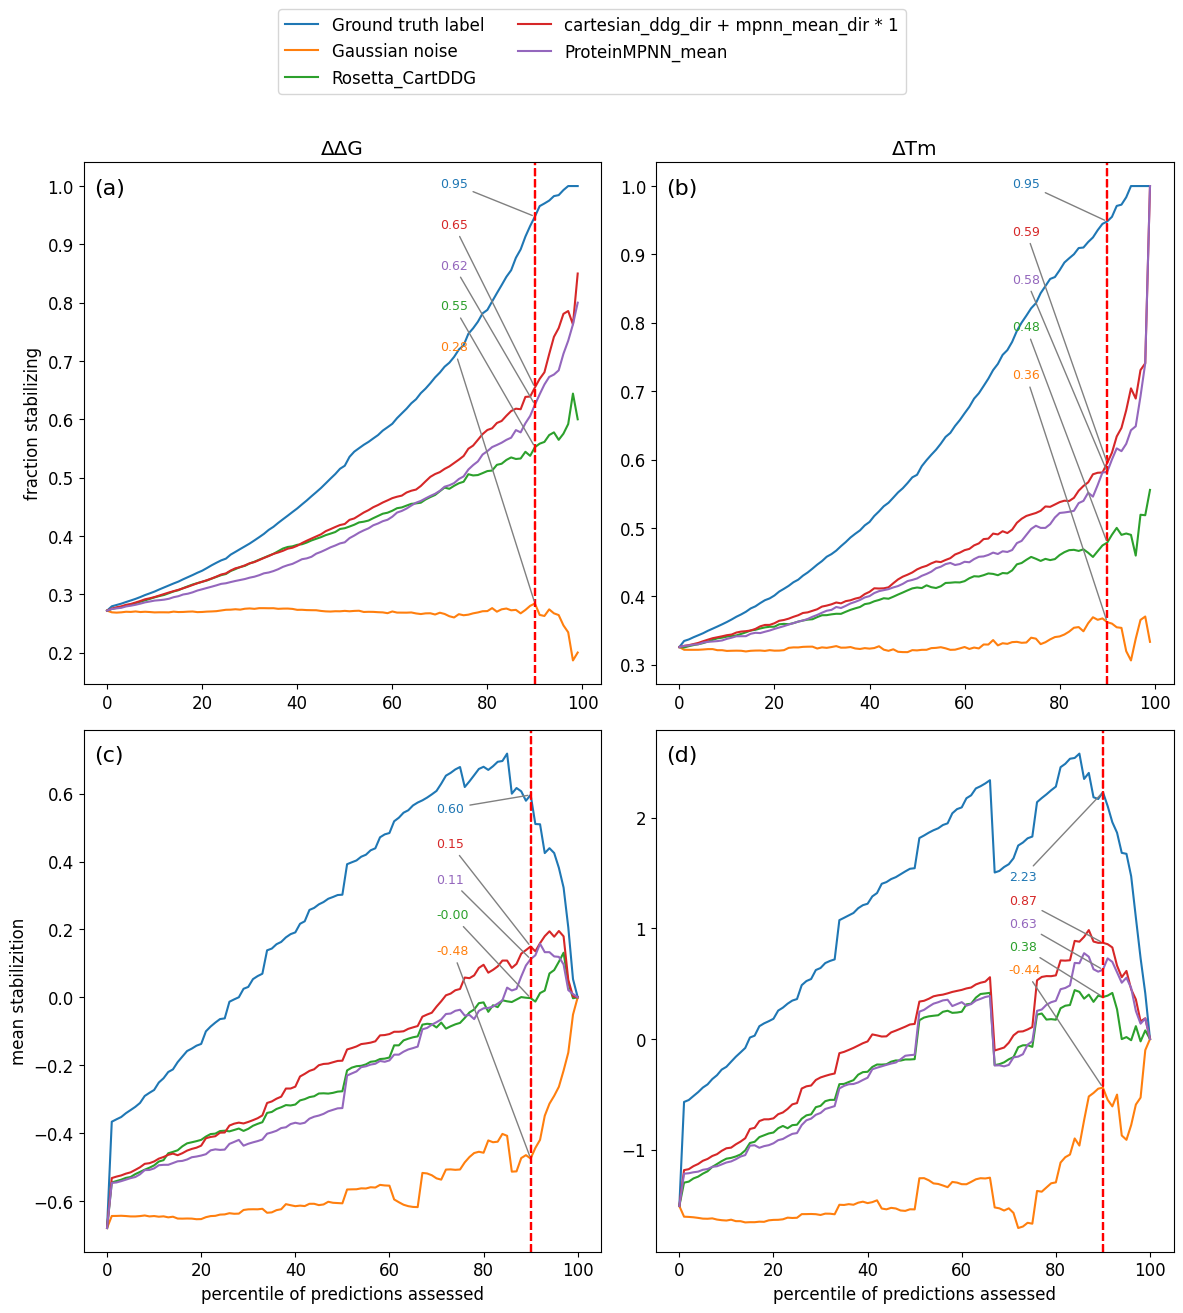

In [ ]:
# extra figure (not in text)
analysis_utils.recovery_curves(d1.reset_index(), ['mpnn_mean_dir', 'cartesian_ddg_dir', 'cartesian_ddg_dir + mpnn_mean_dir * 1', 'ddG_dir', 'dTm_dir', 'random_dir'], spacing=0.07)

  0%|          | 0/100 [00:00<?, ?it/s]

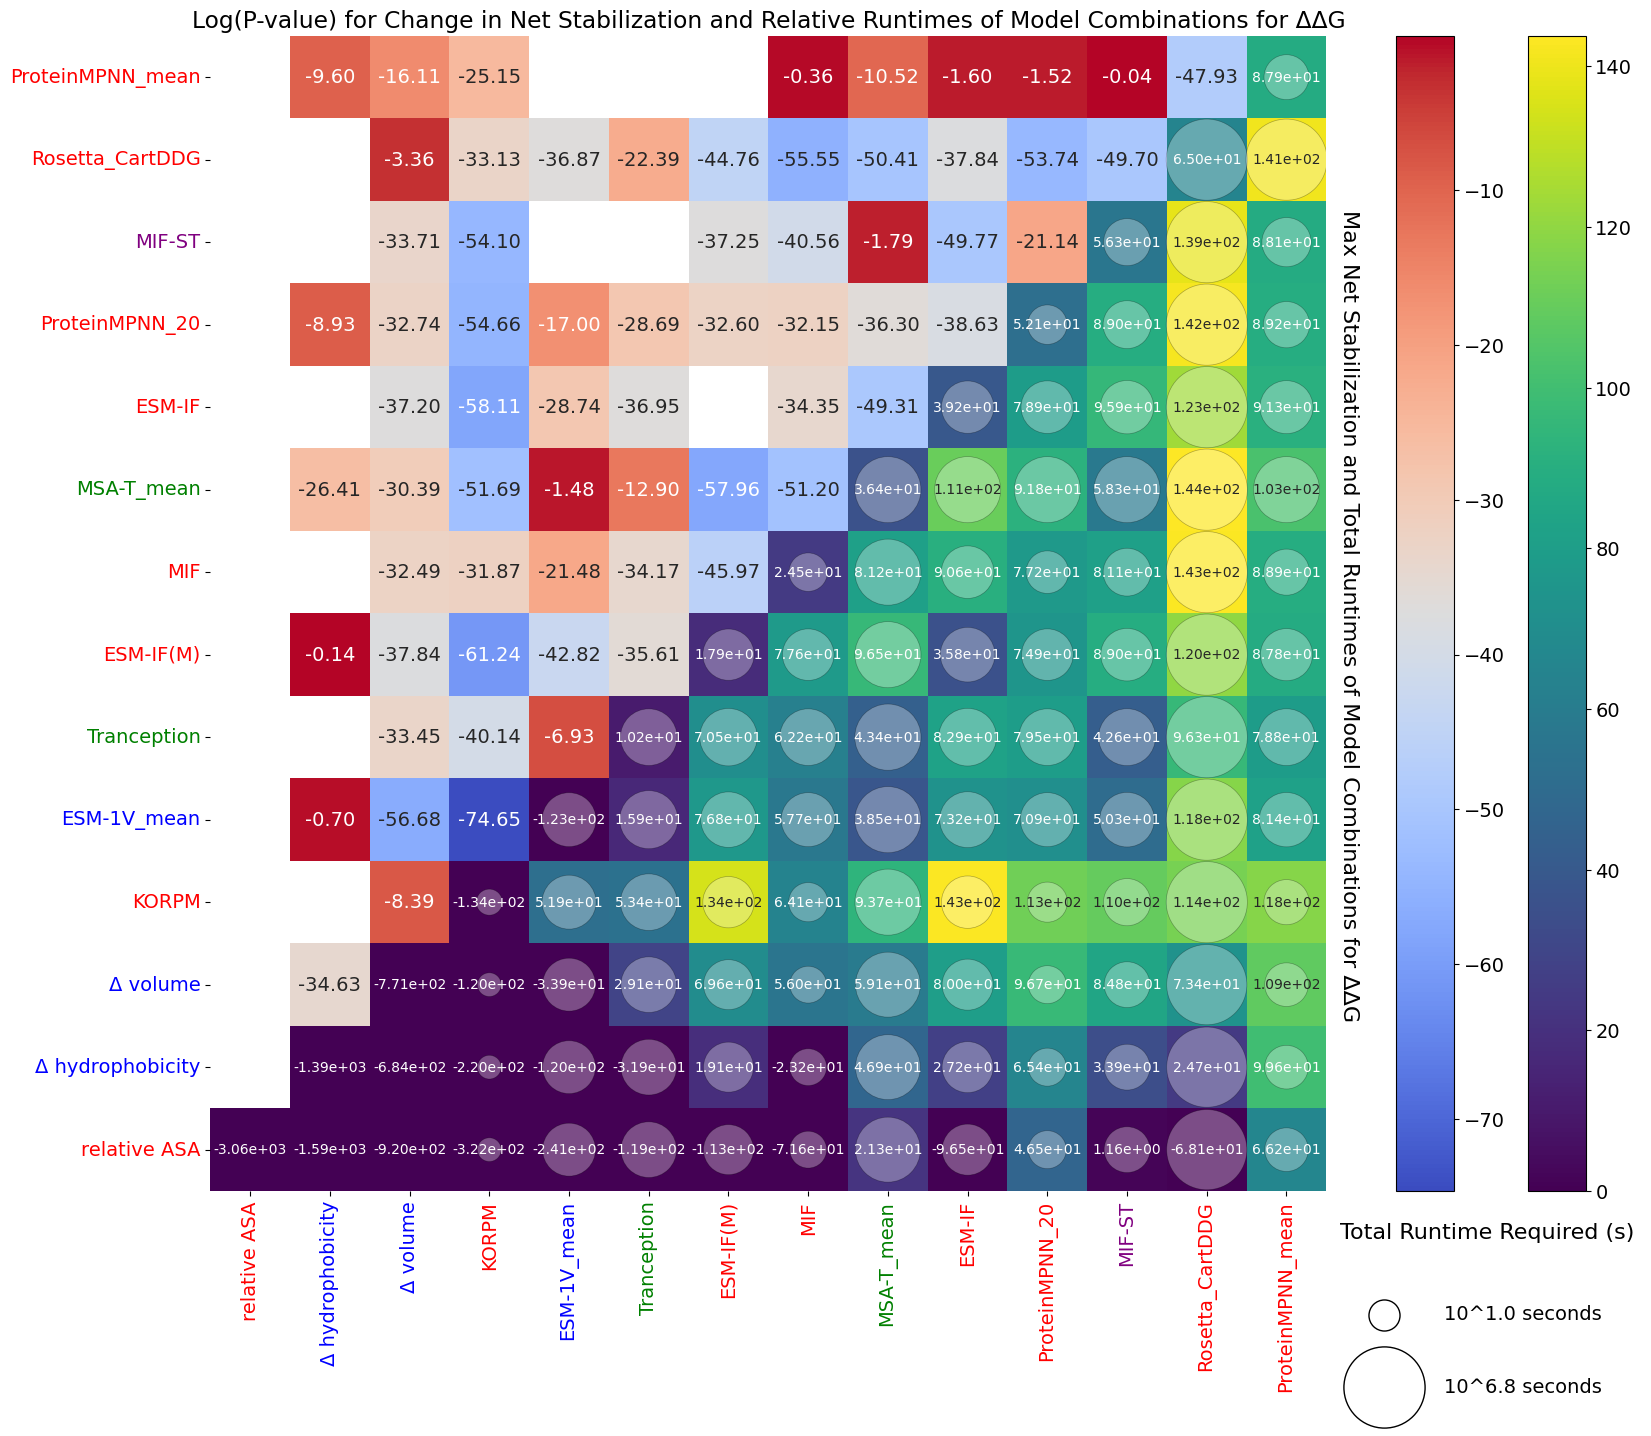

rank              model1 weight1                    model2 weight2  \
0       1   cartesian_ddg_dir       1  msa_transformer_mean_dir     0.2   
1       1   cartesian_ddg_dir       1                   mif_dir     0.5   
2       1  esmif_multimer_dir       1                 korpm_dir     0.5   
3       1   cartesian_ddg_dir       1            mpnn_20_00_dir     0.2   
4       1   cartesian_ddg_dir       1            mpnn_20_00_dir       1   
..    ...                 ...     ...                       ...     ...   
450     1         rel_ASA_dir       1             delta_vol_dir     0.5   
451     1         rel_ASA_dir       1                 korpm_dir     0.2   
452     1         rel_ASA_dir       1             delta_kdh_dir     0.5   
453     1         rel_ASA_dir       1             delta_vol_dir     0.2   
454     1         rel_ASA_dir       1             delta_kdh_dir     0.2   

    mean_net_stabilization p_value  
0                 143.7855     0.0  
1                 143.1665     0.0  
2                142.90925     0.0  
3                 141.6651     0.0  
4                140.97535     0.0  
..                     ...     ...  
450            -2127.70325     0.0  
451             -2192.5537     0.0  
452            -2353.53705     0.0  
453            -2589.68455     0.0  
454              -2625.669     0.0  

[455 rows x 7 columns]

In [ ]:
# Figure 3

custom_colors = {
                 'cartesian_ddg_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 'msa_transformer_mean_dir': 'green',
                 'tranception_dir': 'green',
                 'esmif_monomer_dir': 'red',
                 'esmif_multimer_dir': 'red',
                 #'esmif_multimer_full_masked_dir': 'red',
                 #'mpnn_10_00_dir': 'red',
                 'mpnn_mean_dir': 'red',
                 'mpnn_20_00_dir': 'red',
                 #'mpnn_30_00_dir': 'red',
                 #'mpnn_30_03_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'purple',
                 'korpm_dir': 'red',
                 'delta_kdh_dir': 'blue',
                 'delta_vol_dir': 'blue',
                 #'delta_chg_dir': 'blue',
                 'rel_ASA_dir': 'red',
                }

measurement = 'ddG'
statistic = 'net_stabilization'

d3 = d1.copy(deep=True)
d3 = d3.reset_index()
d3 = d3.set_index(['measurement', 'model_type', 'model', 'class'])
d3 = d3.drop([c for c in d3.columns if 'pos_' in c], axis=1)

stat_df, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm, db_measurements, statistic, measurement, n_bootstraps=100, threshold=0, custom_colors=custom_colors)
stat_df = stat_df.sort_values(f'mean_{statistic}', ascending=False).drop_duplicates(subset=['weight1', 'weight2', f'mean_{statistic}', 'p_value']).reset_index()
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1

stat_df.to_csv('~/zs_suppl/model_combinations_ddG_net_stab_nonneg_test.csv')
stat_df

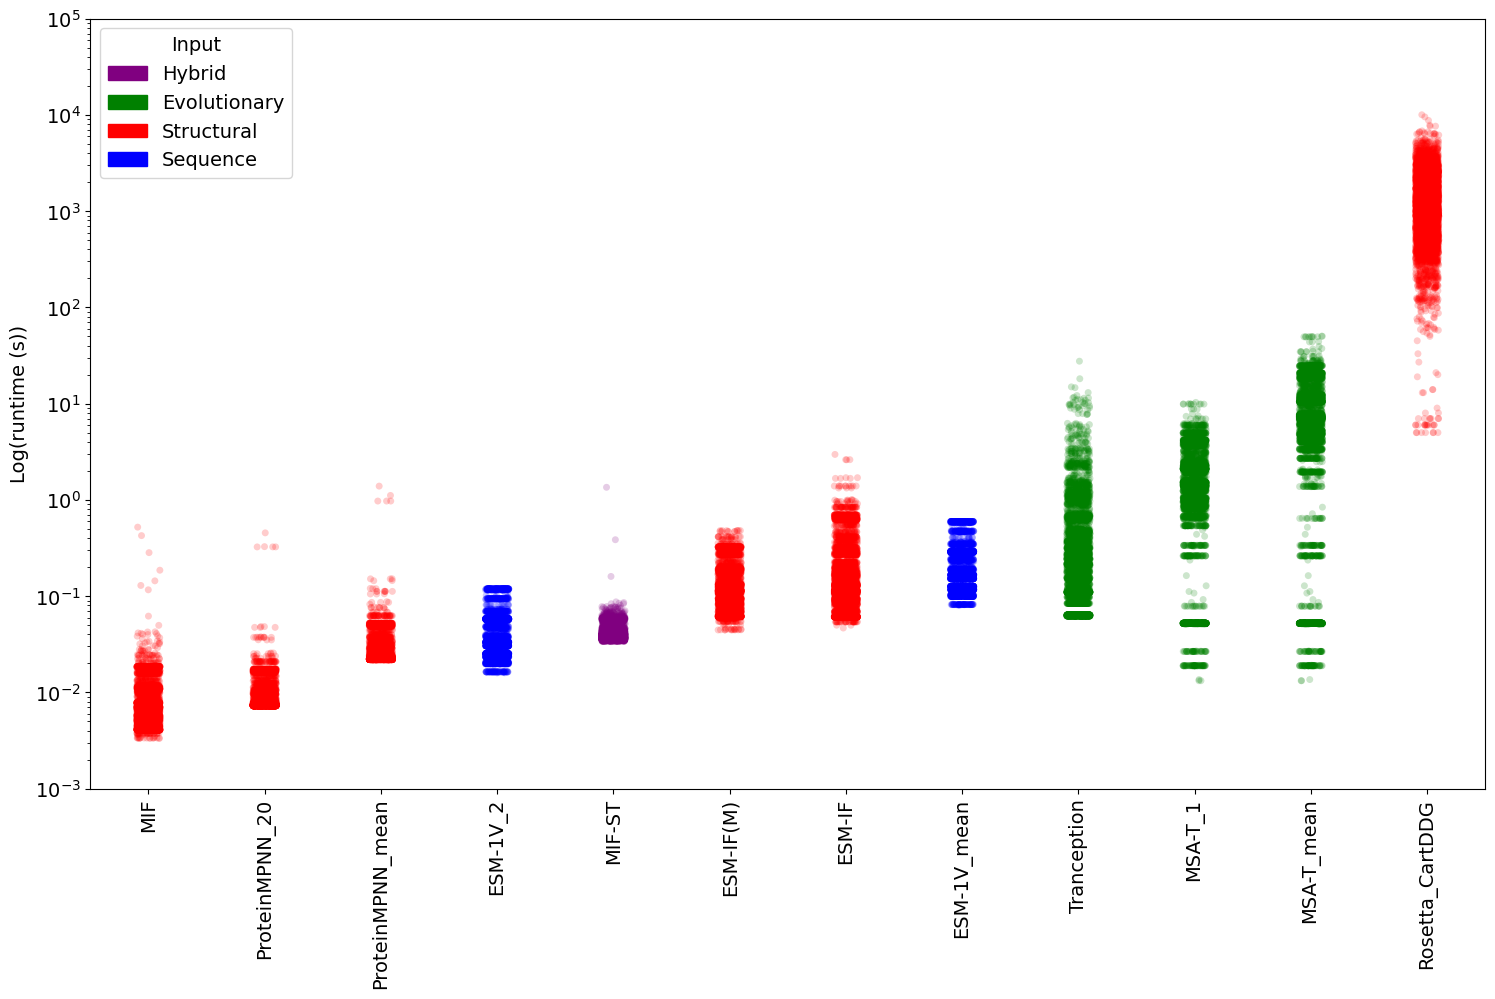

In [ ]:
# SUPPLEMENTARY FIGURE 5

int_runtimes = db_runtimes.dropna(axis=1, how='all')#.groupby('code').mean()#.sum() #uncomment to get mean per protein
int_runtimes = int_runtimes[[
                             'runtime_esmif_monomer_dir',
                             'runtime_esmif_multimer_dir',
                             'runtime_mif_dir',
                             'runtime_mifst_dir',
                             'runtime_mpnn_20_00_dir',
                             'runtime_mpnn_mean_dir',
                             'runtime_tranception_dir',
                             'runtime_msa_transformer_mean_dir',
                             'runtime_msa_1_dir',
                             'runtime_esm1v_mean_dir',
                             'runtime_esm1v_2_dir',
                             'runtime_cartesian_ddg_dir',
                            ]]

int_runtimes.columns = [c[8:-4] for c in int_runtimes.columns]
total_runtimes = int_runtimes.melt().sort_values('value')#.sum(axis=0)

### determine order for displaying runtimes
# Calculate the grouped median
grouped_median = total_runtimes.groupby('variable')['value'].median()
# Create a temporary column 'group_median' with the grouped medians mapped to each row
total_runtimes['group_median'] = total_runtimes['variable'].map(grouped_median)
# Sort the DataFrame first by 'group_median' and then by 'variable'
df_sorted = total_runtimes.sort_values(['group_median', 'variable'], ascending=True)
# Drop the temporary column 'group_median'
total_runtimes = df_sorted.drop(columns=['group_median'])

hybrid = ['mifst']
evolutionary = ['tranception', 'msa_transformer_mean', 'msa_1']
sequence = ['esm1v_mean', 'esm1v_2']
structural = ['cartesian_ddg', 'esmif_multimer', 'esmif_multimer', 'esmif_monomer', 'mpnn_20_00', 'mpnn_mean', 'mif', 'korpm']

cmap = {}
for h in hybrid:
    cmap.update({h: 'purple'})
for e in evolutionary:
    cmap.update({e: 'green'})
for s in structural:
    cmap.update({s: 'red'})
for s in sequence:
    cmap.update({s: 'blue'})

hybrid_patch = Patch(color='purple', label='Hybrid')
evolutionary_patch = Patch(color='green', label='Evolutionary')
structural_patch = Patch(color='red', label='Structural')
sequence_patch = Patch(color='blue', label='Sequence')

fig, ax = plt.subplots(figsize=(1.5*total_runtimes['variable'].nunique(), 10))  # adjust the size here
ax = sns.stripplot(data=total_runtimes, x='variable', y='value', palette=cmap, alpha=0.2)
ax.legend(handles=[hybrid_patch, evolutionary_patch, structural_patch, sequence_patch], title='Input', loc='upper left')

remapped_x = [remap_names[tick.get_text()] if tick.get_text() in remap_names.keys() else tick.get_text() for tick in ax.get_xticklabels()]
ax.set_xticklabels(remapped_x)
ax.set_yticklabels(remapped_x[::-1])
plt.yscale('log')
plt.ylim(10e-4, 10e4)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Log(runtime (s))')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

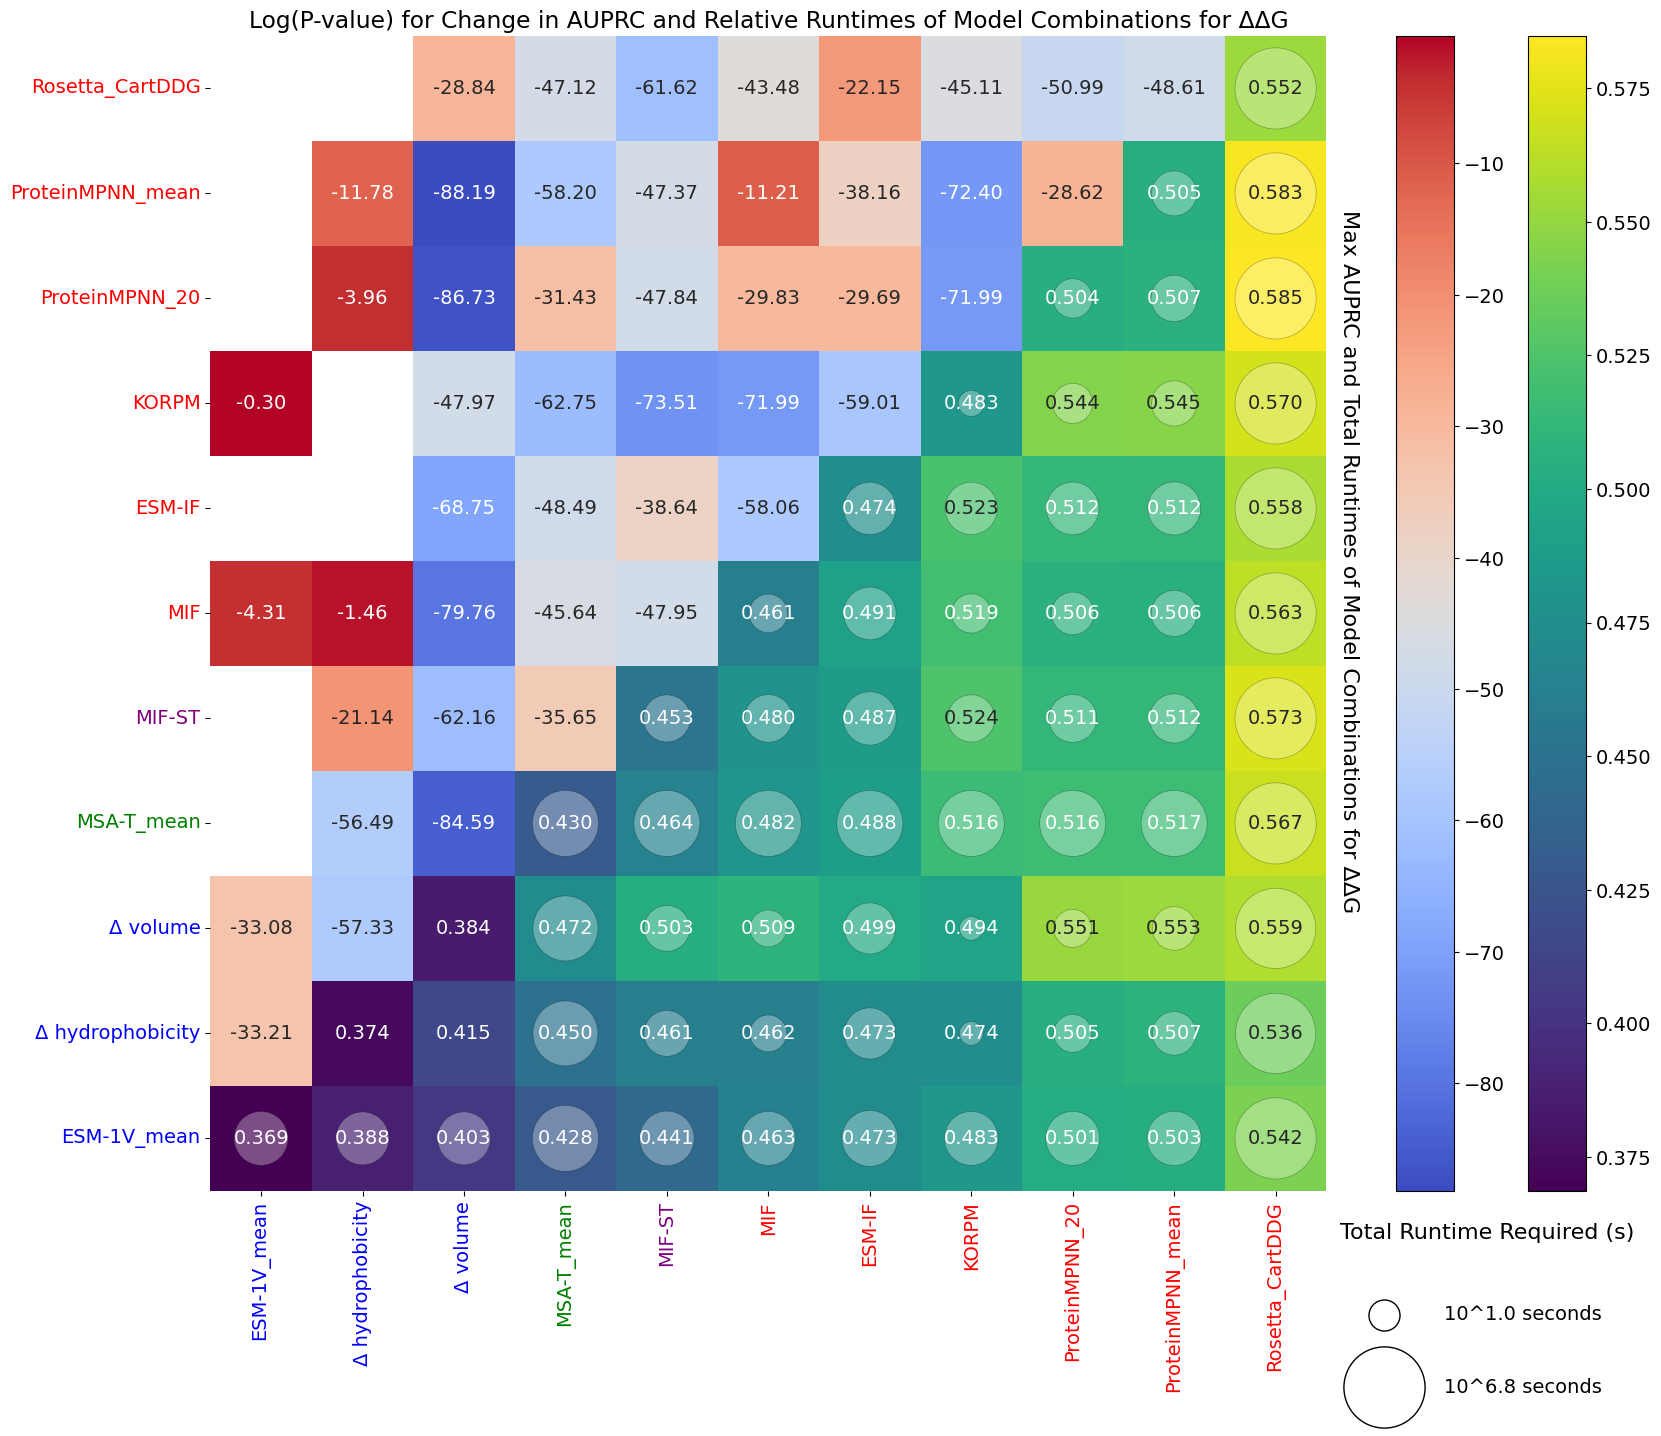

rank             model1 weight1                    model2 weight2  \
0      1  cartesian_ddg_dir       1            mpnn_20_00_dir     0.5   
1      1  cartesian_ddg_dir       1             mpnn_mean_dir     0.5   
2      1  cartesian_ddg_dir       1            mpnn_20_00_dir     0.2   
3      1  cartesian_ddg_dir       1             mpnn_mean_dir     0.2   
4      1     mpnn_20_00_dir       1         cartesian_ddg_dir       1   
5      1  cartesian_ddg_dir       1                 mifst_dir     0.2   
6      1      mpnn_mean_dir       1         cartesian_ddg_dir       1   
7      1  cartesian_ddg_dir       1                 mifst_dir     0.5   
8      1  cartesian_ddg_dir       1                 korpm_dir     0.5   
9      1  cartesian_ddg_dir       1                 korpm_dir     0.2   
10     1  cartesian_ddg_dir       1  msa_transformer_mean_dir     0.2   
11     1  cartesian_ddg_dir       1                   mif_dir     0.2   
12     1  cartesian_ddg_dir       1                   mif_dir     0.5   
13     1  cartesian_ddg_dir       1                 korpm_dir       1   
14     1  cartesian_ddg_dir       1             delta_vol_dir     0.2   
15     1  cartesian_ddg_dir       1        esmif_multimer_dir     0.2   
16     1  cartesian_ddg_dir       1  msa_transformer_mean_dir     0.5   
17     1  cartesian_ddg_dir       1        esmif_multimer_dir     0.5   
18     1      mpnn_mean_dir       1             delta_vol_dir     0.5   
19     1     mpnn_20_00_dir       1         cartesian_ddg_dir     0.5   
20     1      mpnn_mean_dir       1         cartesian_ddg_dir     0.5   
21     1     mpnn_20_00_dir       1             delta_vol_dir     0.5   
22     1  cartesian_ddg_dir       1        esmif_multimer_dir       1   
23     1            mif_dir       1         cartesian_ddg_dir       1   
24     1          korpm_dir       1             mpnn_mean_dir       1   
25     1  cartesian_ddg_dir       1                 mifst_dir       1   
26     1          korpm_dir       1            mpnn_20_00_dir       1   
27     1          korpm_dir       1         cartesian_ddg_dir     0.5   
28     1  cartesian_ddg_dir       1             delta_vol_dir     0.5   
29     1  cartesian_ddg_dir       1            esm1v_mean_dir     0.2   

   mean_auprc   p_value  
0    0.584816       0.0  
1    0.582939       0.0  
2    0.579432       0.0  
3    0.577807       0.0  
4    0.573029       0.0  
5     0.57293       0.0  
6    0.571522       0.0  
7    0.570431       0.0  
8    0.569926       0.0  
9    0.566644       0.0  
10   0.566538       0.0  
11   0.563417       0.0  
12   0.561452       0.0  
13   0.561223       0.0  
14   0.559239       0.0  
15    0.55776       0.0  
16   0.556685   0.00004  
17   0.555789  0.000137  
18   0.552546       0.0  
19   0.551624  0.618506  
20   0.551494  0.569128  
21   0.551154       0.0  
22    0.54803  0.000457  
23   0.546056  0.000002  
24     0.5454       0.0  
25   0.544823       0.0  
26   0.544297       0.0  
27   0.542947       0.0  
28   0.542509       0.0  
29   0.542026       0.0

In [ ]:
# SUPPLEMENTARY FIGURE 6

measurement = 'ddG'
statistic = 'auprc'

stat_df, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm, db_measurements, statistic, measurement, n_bootstraps=100, custom_colors=custom_colors)
stat_df = stat_df.sort_values(f'mean_{statistic}', ascending=False).drop_duplicates(subset=['weight1', 'weight2', f'mean_{statistic}', 'p_value']).reset_index()
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1

#stat_df.to_csv('../../zs_suppl/model_combinations_ddG_auprc_nonneg.csv')
stat_df.head(30)


  0%|          | 0/100 [00:00<?, ?it/s]

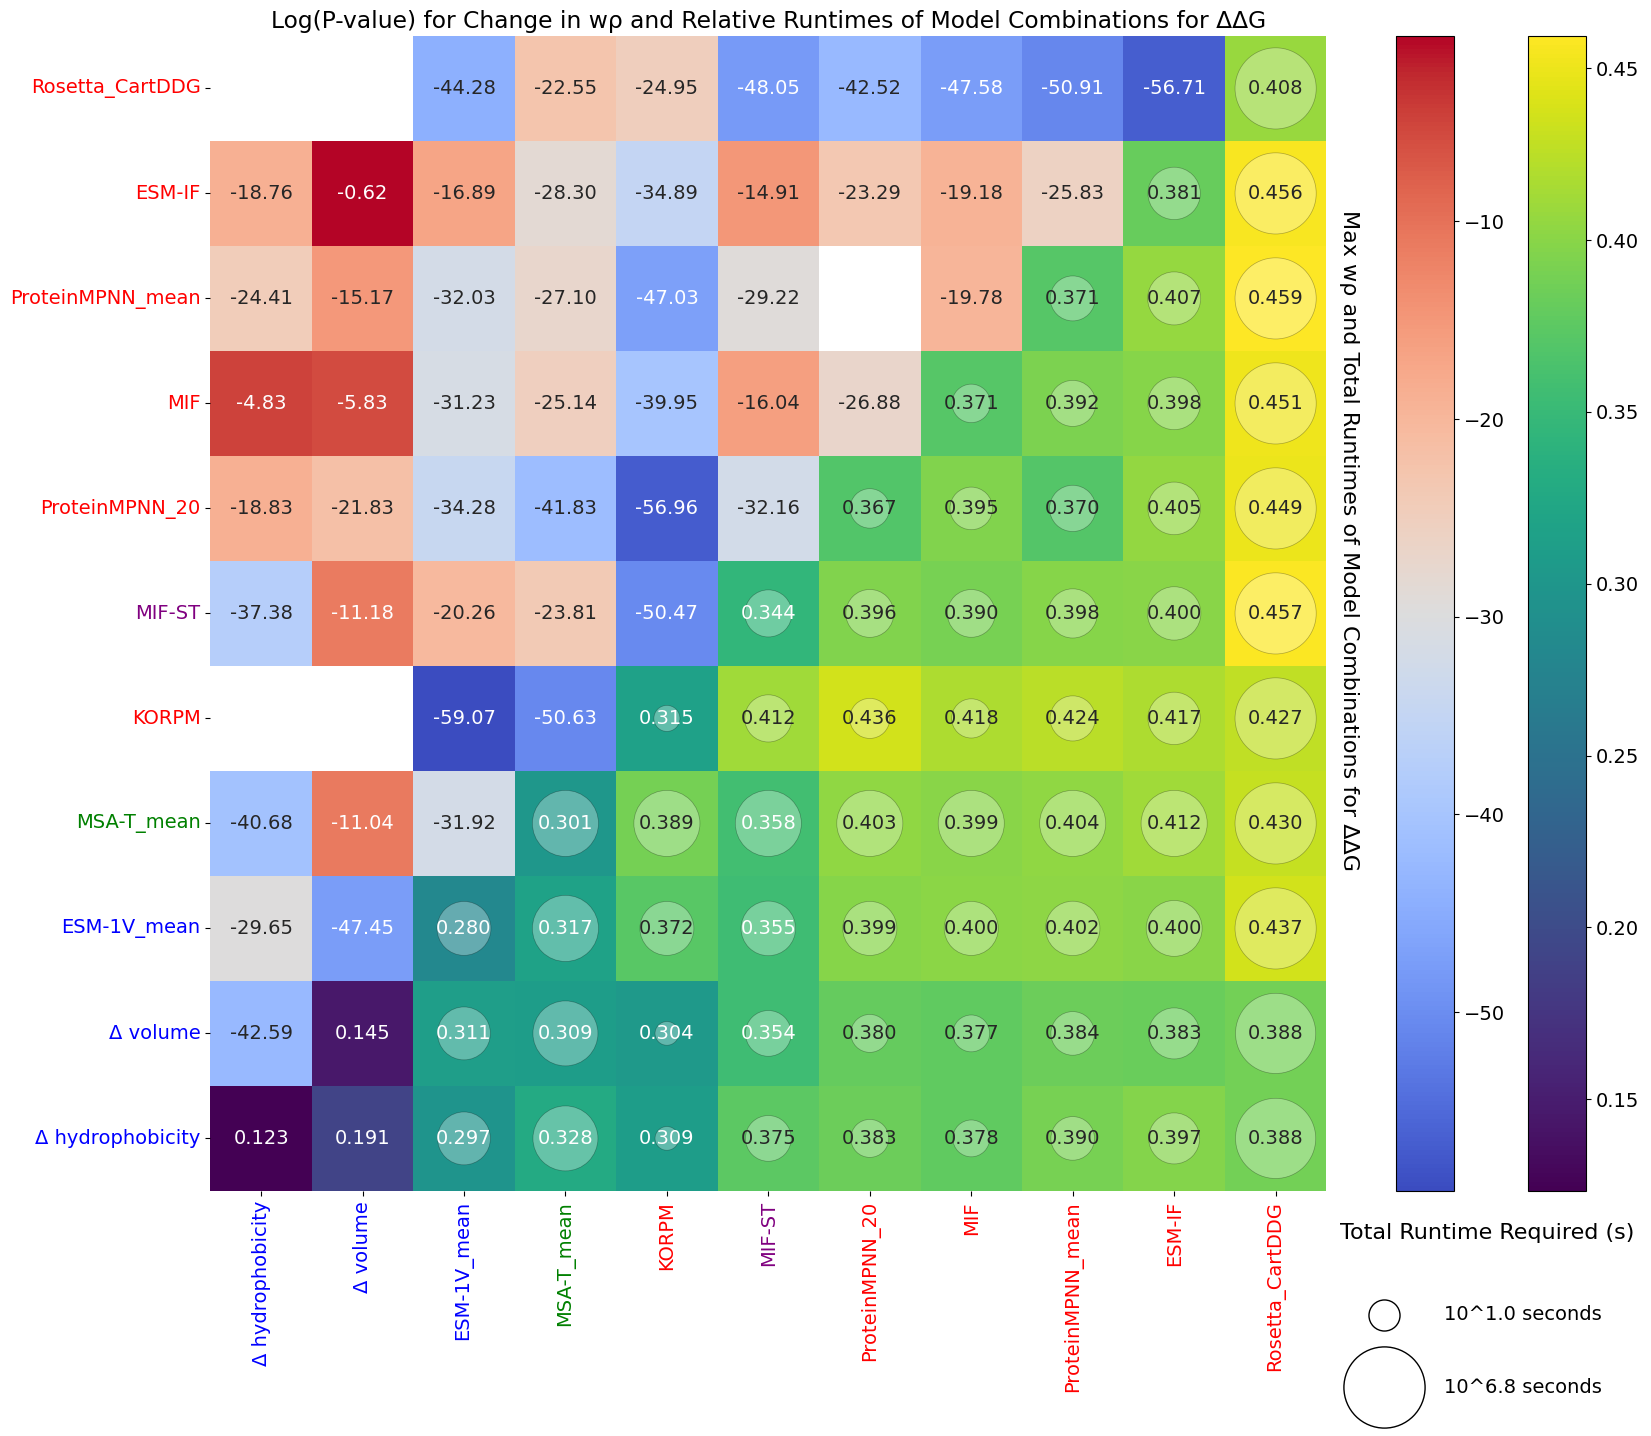

rank                    model1 weight1                    model2 weight2  \
0      1         cartesian_ddg_dir       1             mpnn_mean_dir     0.5   
1      1         cartesian_ddg_dir       1                 mifst_dir     0.5   
2      1         cartesian_ddg_dir       1        esmif_multimer_dir     0.5   
3      1         cartesian_ddg_dir       1                 mifst_dir       1   
4      1         cartesian_ddg_dir       1                   mif_dir     0.5   
5      1         cartesian_ddg_dir       1        esmif_multimer_dir       1   
6      1         cartesian_ddg_dir       1             mpnn_mean_dir       1   
7      1         cartesian_ddg_dir       1            mpnn_20_00_dir     0.5   
8      1         cartesian_ddg_dir       1                 mifst_dir     0.2   
9      1         cartesian_ddg_dir       1                   mif_dir       1   
10     1         cartesian_ddg_dir       1            mpnn_20_00_dir       1   
11     1         cartesian_ddg_dir       1            esm1v_mean_dir     0.2   
12     1         cartesian_ddg_dir       1             mpnn_mean_dir     0.2   
13     1            mpnn_20_00_dir       1                 korpm_dir       1   
14     1         cartesian_ddg_dir       1        esmif_multimer_dir     0.2   
15     1         cartesian_ddg_dir       1            esm1v_mean_dir     0.5   
16     1        esmif_multimer_dir       1         cartesian_ddg_dir     0.5   
17     1         cartesian_ddg_dir       1            mpnn_20_00_dir     0.2   
18     1         cartesian_ddg_dir       1                   mif_dir     0.2   
19     1         cartesian_ddg_dir       1  msa_transformer_mean_dir     0.5   
20     1         cartesian_ddg_dir       1  msa_transformer_mean_dir     0.2   
21     1             mpnn_mean_dir       1         cartesian_ddg_dir     0.5   
22     1         cartesian_ddg_dir       1                 korpm_dir     0.5   
23     1            mpnn_20_00_dir       1         cartesian_ddg_dir     0.5   
24     1                   mif_dir       1         cartesian_ddg_dir     0.5   
25     1            mpnn_20_00_dir       1                 korpm_dir     0.5   
26     1                 korpm_dir       1             mpnn_mean_dir       1   
27     1  msa_transformer_mean_dir       1         cartesian_ddg_dir       1   
28     1             mpnn_mean_dir       1                 korpm_dir     0.5   
29     1                 korpm_dir       1                   mif_dir       1   

   mean_weighted_spearman p_value  
0                0.459214     0.0  
1                0.456726     0.0  
2                0.456452     0.0  
3                0.451424     0.0  
4                0.451239     0.0  
5                0.449905     0.0  
6                0.449271     0.0  
7                0.449133     0.0  
8                0.444813     0.0  
9                0.441939     0.0  
10               0.439381     0.0  
11               0.436623     0.0  
12               0.436395     0.0  
13               0.435773     0.0  
14               0.434731     0.0  
15               0.434243     0.0  
16               0.432389     0.0  
17               0.430559     0.0  
18               0.430181     0.0  
19               0.430104     0.0  
20               0.429271     0.0  
21               0.428794     0.0  
22               0.426626     0.0  
23               0.425145     0.0  
24               0.424126     0.0  
25               0.423985     0.0  
26               0.423851     0.0  
27               0.421919     0.0  
28               0.421441     0.0  
29               0.418489     0.0

In [ ]:
# SUPPLEMENTARY FIGURE 7

measurement = 'ddG'
statistic = 'weighted_spearman'

stat_df, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm, db_measurements, statistic, measurement, n_bootstraps=100, custom_colors=custom_colors)
stat_df = stat_df.sort_values(f'mean_{statistic}', ascending=False).drop_duplicates(subset=['weight1', 'weight2', f'mean_{statistic}', 'p_value']).reset_index()
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1

#stat_df.to_csv('../../zeroshot suppl/model_combinations_ddG_spearman_nonneg.csv')
stat_df.head(30)

  0%|          | 0/100 [00:00<?, ?it/s]

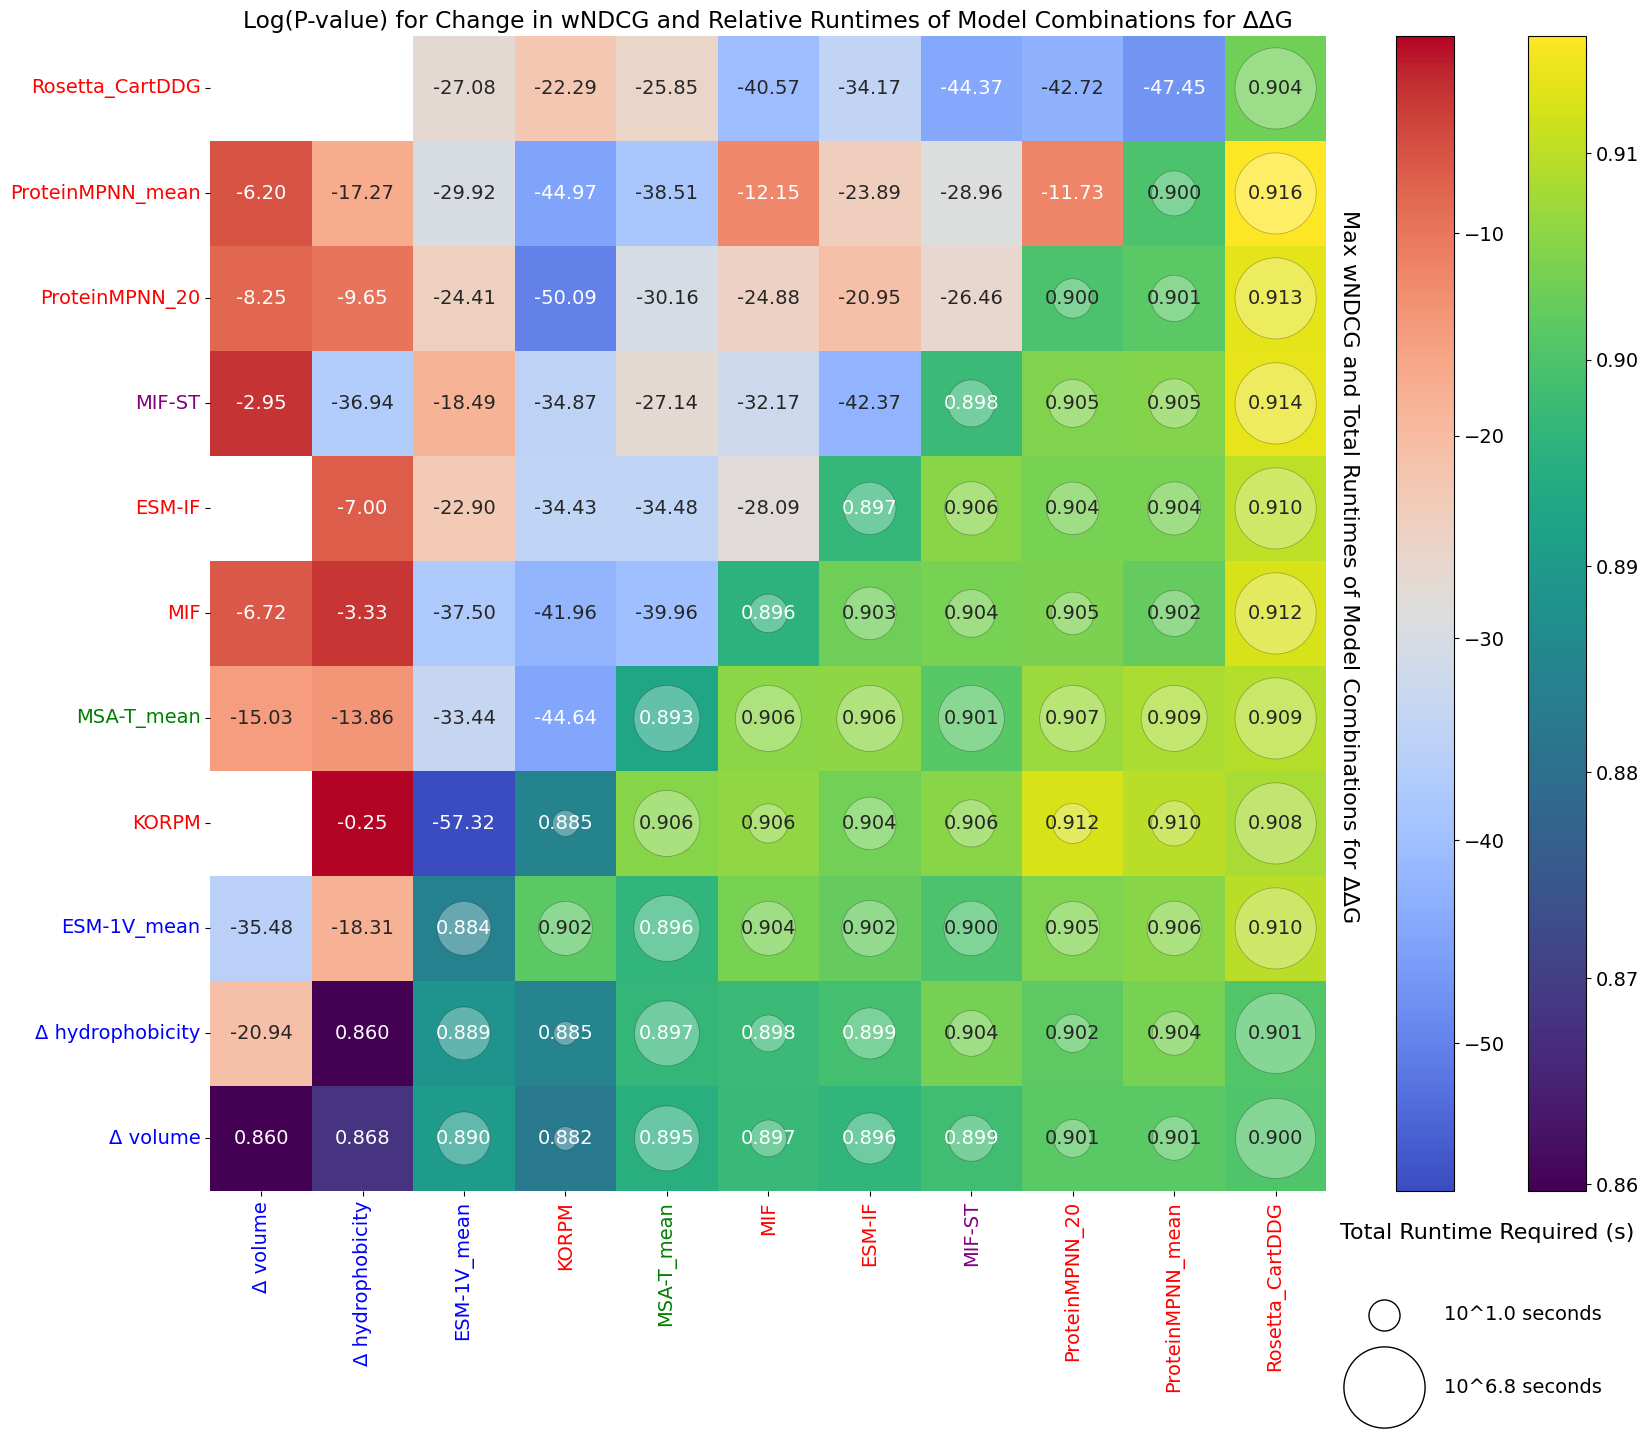

rank                    model1 weight1                    model2 weight2  \
0      1         cartesian_ddg_dir       1             mpnn_mean_dir     0.5   
1      1             mpnn_mean_dir       1         cartesian_ddg_dir       1   
2      1         cartesian_ddg_dir       1                 mifst_dir     0.5   
3      1         cartesian_ddg_dir       1            mpnn_20_00_dir     0.5   
4      1         cartesian_ddg_dir       1            mpnn_20_00_dir       1   
5      1         cartesian_ddg_dir       1                   mif_dir     0.5   
6      1                 mifst_dir       1         cartesian_ddg_dir       1   
7      1                 korpm_dir       1            mpnn_20_00_dir       1   
8      1         cartesian_ddg_dir       1                 mifst_dir     0.2   
9      1             mpnn_mean_dir       1         cartesian_ddg_dir     0.5   
10     1         cartesian_ddg_dir       1             mpnn_mean_dir     0.2   
11     1                   mif_dir       1         cartesian_ddg_dir       1   
12     1         cartesian_ddg_dir       1            mpnn_20_00_dir     0.2   
13     1            mpnn_20_00_dir       1         cartesian_ddg_dir     0.5   
14     1         cartesian_ddg_dir       1        esmif_multimer_dir     0.5   
15     1                 korpm_dir       1             mpnn_mean_dir       1   
16     1         cartesian_ddg_dir       1            esm1v_mean_dir     0.5   
17     1            mpnn_20_00_dir       1                 korpm_dir     0.5   
18     1             mpnn_mean_dir       1                 korpm_dir     0.5   
19     1         cartesian_ddg_dir       1  msa_transformer_mean_dir       1   
20     1         cartesian_ddg_dir       1            esm1v_mean_dir     0.2   
21     1         cartesian_ddg_dir       1  msa_transformer_mean_dir     0.5   
22     1  msa_transformer_mean_dir       1             mpnn_mean_dir       1   
23     1                   mif_dir       1         cartesian_ddg_dir     0.5   
24     1         cartesian_ddg_dir       1        esmif_multimer_dir     0.2   
25     1         cartesian_ddg_dir       1                 korpm_dir     0.5   
26     1         cartesian_ddg_dir       1        esmif_multimer_dir       1   
27     1         cartesian_ddg_dir       1  msa_transformer_mean_dir     0.2   
28     1         cartesian_ddg_dir       1                   mif_dir     0.2   
29     1            esm1v_mean_dir       1         cartesian_ddg_dir       1   

   mean_weighted_ndcg p_value  
0            0.915705     0.0  
1            0.913588     0.0  
2            0.913528     0.0  
3             0.91345     0.0  
4            0.912709     0.0  
5            0.912331     0.0  
6            0.912264     0.0  
7            0.912239     0.0  
8            0.911737     0.0  
9            0.910873     0.0  
10           0.910761     0.0  
11           0.910298     0.0  
12           0.910258     0.0  
13           0.910138     0.0  
14           0.910111     0.0  
15           0.909998     0.0  
16           0.909894     0.0  
17           0.909719     0.0  
18           0.909561     0.0  
19           0.909464     0.0  
20            0.90923     0.0  
21           0.909121     0.0  
22           0.908641     0.0  
23           0.908509     0.0  
24           0.908459     0.0  
25           0.908347     0.0  
26           0.908242     0.0  
27           0.908228     0.0  
28           0.907419     0.0  
29           0.907305     0.0

In [ ]:
# SUPPLEMENTARY FIGURE 8

measurement = 'ddG'
statistic = 'weighted_ndcg'

stat_df, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm, db_measurements, statistic, measurement, n_bootstraps=100, custom_colors=custom_colors)
stat_df = stat_df.sort_values(f'mean_{statistic}', ascending=False).drop_duplicates(subset=['weight1', 'weight2', f'mean_{statistic}', 'p_value']).reset_index()
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1

stat_df.to_csv('../../zs_suppl/model_combinations_ddG_ndcg_nonneg.csv')
stat_df.head(30)


  0%|          | 0/100 [00:00<?, ?it/s]

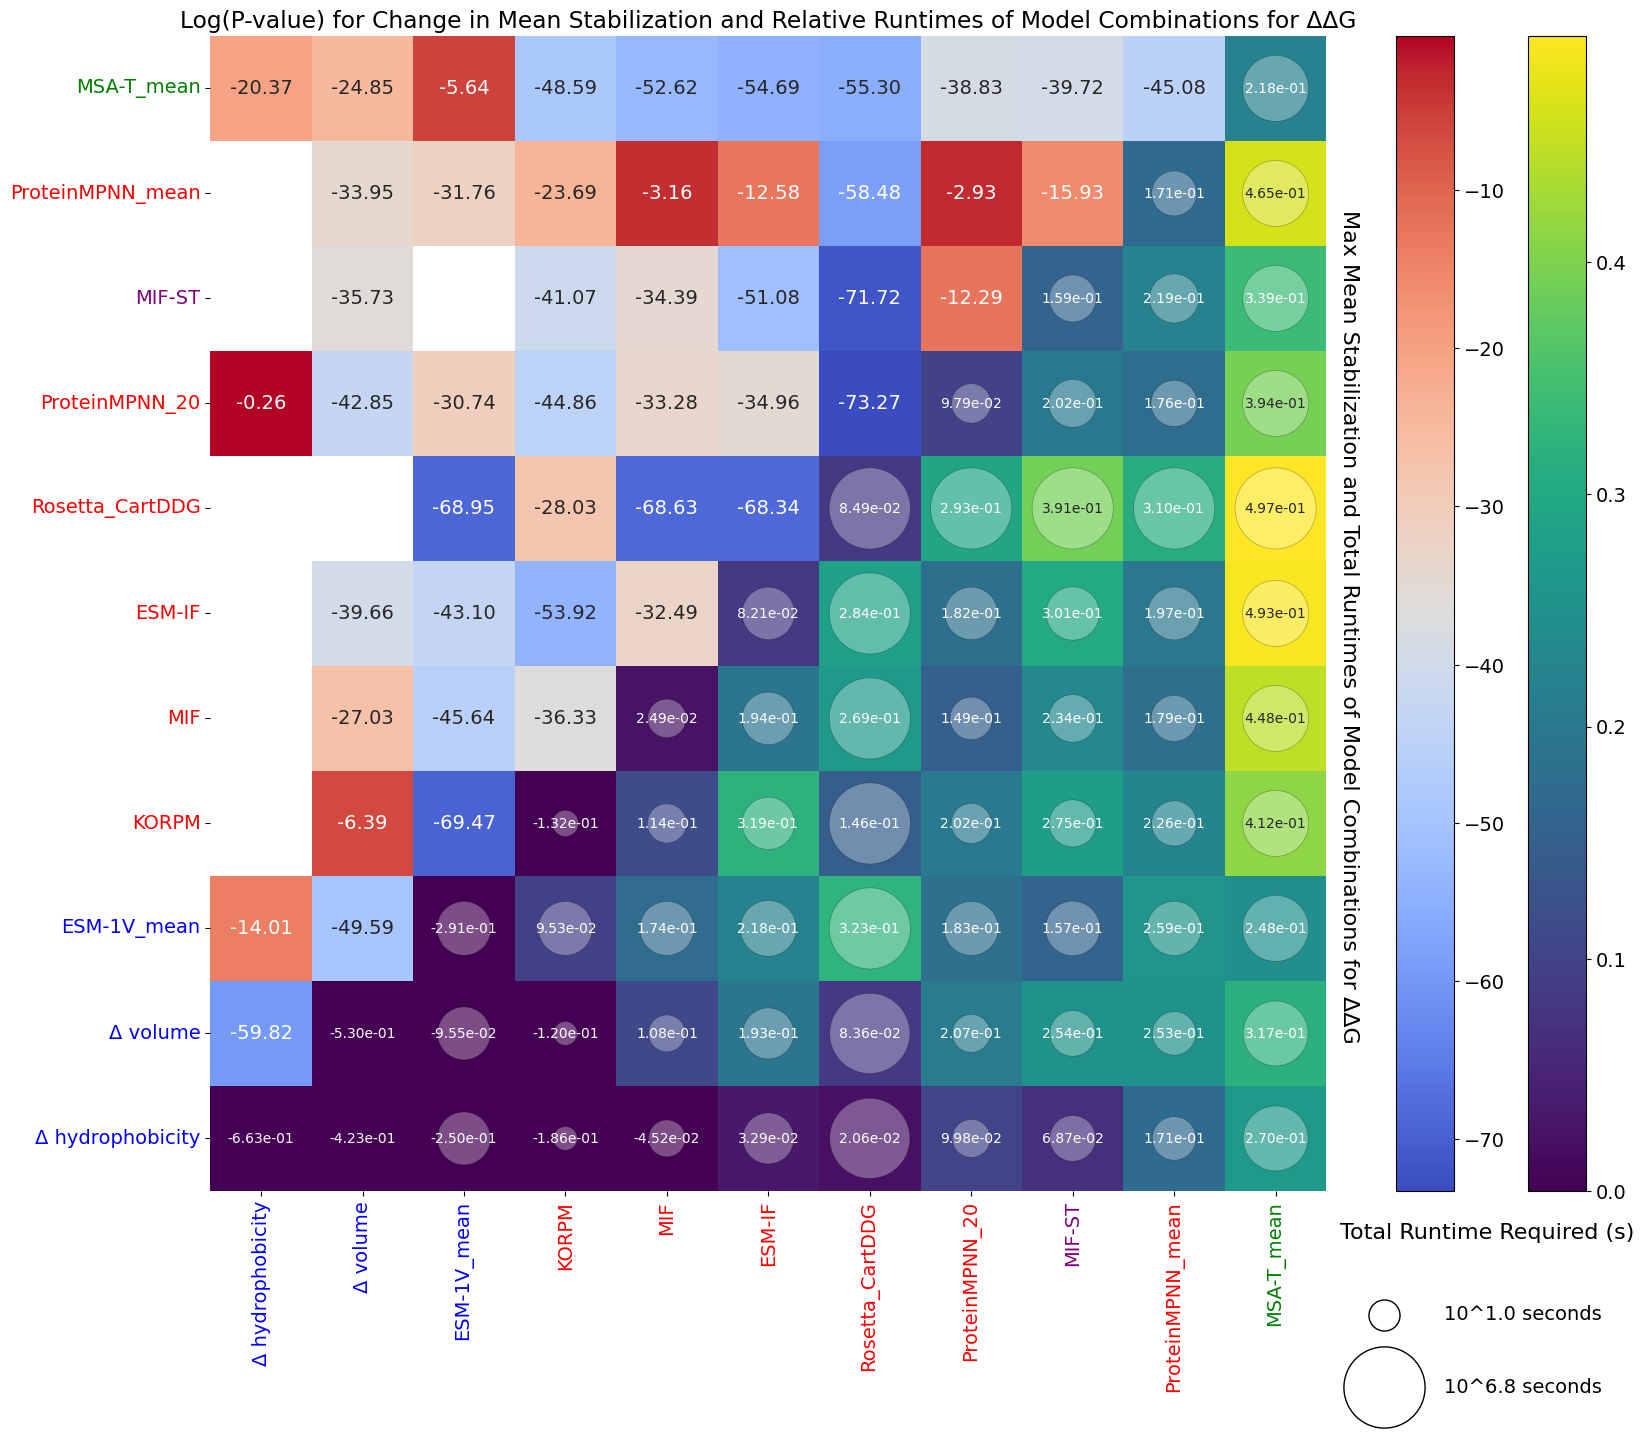

rank                    model1 weight1                    model2 weight2  \
0      1         cartesian_ddg_dir       1  msa_transformer_mean_dir       1   
1      1        esmif_multimer_dir       1  msa_transformer_mean_dir     0.5   
2      1  msa_transformer_mean_dir       1         cartesian_ddg_dir     0.5   
3      1             mpnn_mean_dir       1  msa_transformer_mean_dir     0.5   
4      1        esmif_multimer_dir       1  msa_transformer_mean_dir     0.2   
5      1  msa_transformer_mean_dir       1        esmif_multimer_dir       1   
6      1  msa_transformer_mean_dir       1                   mif_dir       1   
7      1         cartesian_ddg_dir       1  msa_transformer_mean_dir     0.5   
8      1  msa_transformer_mean_dir       1             mpnn_mean_dir       1   
9      1  msa_transformer_mean_dir       1        esmif_multimer_dir     0.5   
10     1  msa_transformer_mean_dir       1                   mif_dir     0.5   
11     1  msa_transformer_mean_dir       1                 korpm_dir     0.5   
12     1  msa_transformer_mean_dir       1             mpnn_mean_dir     0.5   
13     1                   mif_dir       1  msa_transformer_mean_dir     0.5   
14     1  msa_transformer_mean_dir       1            mpnn_20_00_dir       1   
15     1  msa_transformer_mean_dir       1            mpnn_20_00_dir     0.5   
16     1                 mifst_dir       1         cartesian_ddg_dir       1   
17     1  msa_transformer_mean_dir       1                 korpm_dir       1   
18     1            mpnn_20_00_dir       1  msa_transformer_mean_dir     0.5   
19     1  msa_transformer_mean_dir       1                   mif_dir     0.2   
20     1  msa_transformer_mean_dir       1        esmif_multimer_dir     0.2   
21     1  msa_transformer_mean_dir       1             mpnn_mean_dir     0.2   
22     1         cartesian_ddg_dir       1                 mifst_dir     0.5   
23     1  msa_transformer_mean_dir       1         cartesian_ddg_dir     0.2   
24     1         cartesian_ddg_dir       1  msa_transformer_mean_dir     0.2   
25     1  msa_transformer_mean_dir       1                 korpm_dir     0.2   
26     1  msa_transformer_mean_dir       1            mpnn_20_00_dir     0.2   
27     1  msa_transformer_mean_dir       1                 mifst_dir     0.2   
28     1  msa_transformer_mean_dir       1                 mifst_dir     0.5   
29     1                 mifst_dir       1         cartesian_ddg_dir     0.5   

   mean_mean_stabilization p_value  
0                  0.49744     0.0  
1                 0.493496     0.0  
2                 0.467735     0.0  
3                 0.465199     0.0  
4                 0.464628     0.0  
5                 0.460462     0.0  
6                 0.448333     0.0  
7                  0.44821     0.0  
8                  0.44314     0.0  
9                 0.430223     0.0  
10                0.417342     0.0  
11                 0.41203     0.0  
12                0.399926     0.0  
13                0.398338     0.0  
14                0.393579     0.0  
15                0.392994     0.0  
16                0.391231     0.0  
17                0.387054     0.0  
18                0.382719     0.0  
19                0.377524     0.0  
20                0.375782     0.0  
21                0.373237     0.0  
22                0.367666     0.0  
23                0.367621     0.0  
24                0.365112     0.0  
25                0.357854     0.0  
26                0.350393     0.0  
27                0.338501     0.0  
28                0.334093     0.0  
29                 0.32348     0.0

In [ ]:
# SUPPLEMENTARY FIGURE 9

measurement = 'ddG'
statistic = 'mean_stabilization'

stat_df, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm, db_measurements, statistic, measurement, n_bootstraps=100, threshold=0, custom_colors=custom_colors)
stat_df = stat_df.sort_values(f'mean_{statistic}', ascending=False).drop_duplicates(subset=['weight1', 'weight2', f'mean_{statistic}', 'p_value']).reset_index()
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1

#stat_df.to_csv('../../zs_suppl/model_combinations_ddG_mean_stab_nonneg.csv')
stat_df.head(30)

In [ ]:
# preprocessing for feature comparisons between datasets

db_feats_2['neff'] = db_feats_2['neff'].fillna(0)
fp_feats = db_feats_2
fp_feats['neff'] = fp_feats['neff'].fillna(0)
fp_feats['rel_ASA']

db = pd.read_csv(os.path.join(path, 'data', 's669_mapped.csv'))

db['uid2'] = db['code'] + '_' + (db['position'].astype(int) - db['offset_up'].astype(int)).astype(str) + db['mutation'].str[-1]
db = db.set_index(['uid', 'uid2'])

cols = db.columns
drop = [col for col in db.columns if 'Unnamed' in col]
drop += [col for col in db.columns if 'pdb' in col]
drop += [col for col in db.columns if 'offset' in col]

db_full = db.copy(deep=True)
db_full['uid3'] = db['code'] + '_' + db['PDB_Mut'].str[1:]
db_full = db_full.reset_index().set_index('uid3')

s461 = pd.read_csv(os.path.join(path, 'data', 'S461.csv'))
s461['uid3'] = s461['PDB'] + '_' + s461['MUT_D'].str[2:]
s461 = s461.set_index('uid3')
s461['ddG_I'] = -s461['ddG_D']

s461.columns = [s+'_dir' for s in s461.columns]
s461 = s461.rename({'ddG_D_dir': 'ddG_dir', 'ddG_I_dir': 'ddG_inv'}, axis=1)


db = s461.join(db_full, how='left').reset_index(drop=True).set_index(['uid', 'uid2'])
#db.to_csv(os.path.join(path, '..', 'S461_joined.csv'))
db = db.drop(drop, axis=1)
db = db.drop(['PDB_dir', 'MUT_D_dir'], axis=1)

s669_combined = db.copy(deep=True).reset_index()
s669_combined = s669_combined.set_index('uid').drop(['multimer', 'nmr_xray', 'pH', 'resolution', 'wild_type'], axis=1)

neff = pd.read_csv(os.path.join(path, 'data', 'neff.csv'), header=None).set_index(0)
neff.index.name = 'code'
neff.columns = ['neff', 'sequence_length']

s669_feats = pd.read_csv(os.path.join(path, 'data', 's669_mapped_feats.csv'))
s669_feats['uid'] = s669_feats['code'] + '_' + s669_feats['position'].astype(str) + s669_feats['mutation']
s669_feats = s669_feats[['uid', 'wild_type', 'on_interface', 'entropy', 'conservation', 'column_completeness', 'completeness_score', 'n_seqs', 'structure_length', 'multimer', 'SS',
                        'features', 'hbonds', 'saltbrs', 'b_factor', 'kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'rel_ASA', 'nmr_xray', 'pH', 'resolution']] # 'residue_depth',

s669_feats['on_interface'] = s669_feats['on_interface'].astype(int)
s669_feats['features'] = s669_feats['features'].fillna("")#.apply(list)
#s669_combined = s669_combined.join(ddgs)
s669_combined = s669_combined.join(s669_feats.set_index('uid')).drop('code', axis=1)
s669_combined['delta_kdh'] = s669_combined['kdh_mut'] - s669_combined['kdh_wt']
s669_combined['delta_vol'] = s669_combined['vol_mut'] - s669_combined['vol_wt']
s669_combined['delta_chg'] = s669_combined['chg_mut'] - s669_combined['chg_wt']
s669_combined['delta_asa'] = s669_combined['SOL_ACC_inv'] - s669_combined['SOL_ACC_dir']
s669_combined['to_proline'] = (s669_combined.index.str[-1] == 'P').astype(int)
s669_combined['to_glycine'] = (s669_combined.index.str[-1] == 'G').astype(int)
s669_combined['from_proline'] = s669_combined['wild_type'] == 'P'
s669_combined['from_glycine'] = s669_combined['wild_type'] == 'G'
s669_combined['helix'] = s669_combined['SS'] == 'H'
s669_combined['bend'] = s669_combined['SS'] == 'S'
s669_combined['turn'] = s669_combined['SS'] == 'T'
s669_combined['coil'] = s669_combined['SS'] == '-'
s669_combined['strand'] = s669_combined['SS'] == 'E'
s669_combined['xray_else_NMR'] = s669_combined['nmr_xray'].str.contains('X-RAY')
s669_combined['active_site'] = s669_combined['features'].str.contains('ACT_SITE')
s669_combined['resolution'] = s669_combined['resolution'].fillna('').apply(lambda x: analysis_utils.extract_decimal_number(x))

s669_combined = s669_combined.drop(['kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'features', 'SS', 'wild_type', 'nmr_xray'], axis=1)

s669_combined['code'] = s669_combined.index.str[:4]
s669_combined = s669_combined.reset_index().merge(neff['neff'].dropna(), on='code', how='left')#.drop('code', axis=1)#.set_index('uid')
s669_combined['neff'] = s669_combined['neff'].fillna(0)
unique_indices = s669_combined.groupby('uid')['neff'].idxmax()#.astype(int)
s669_combined = s669_combined.loc[unique_indices].set_index('uid')

s669_combined['random_dir'] = np.random.rand(len(s669_combined)) - 0.5
s669_combined['random_inv'] = np.random.rand(len(s669_combined)) - 0.5
s669_combined = s669_combined.rename({'ddG_dir': 'ddG'}, axis=1)

s461_feats = s669_combined
s461_feats['rel_ASA']

uid
1A0F_11A     0.000000
1BA3_457D    0.190217
1BA3_485D    1.000000
1BA3_485K    1.000000
1BA3_485M    1.000000
               ...   
4HE7_19G     0.764151
4HE7_19K     0.764151
5JXB_25G     0.975460
5JXB_25P     0.975460
5OAQ_199H    0.004505
Name: rel_ASA, Length: 461, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def compare_distributions_violin(df1, df2):
    remap_names = {'delta_chg': 'Δ charge', 'delta_vol': 'Δ volume', 'hbonds': 'wt hydrogen bonds', 
                    'multimer': 'chains in assembly', 'neff': 'n effective sequences', 'b_factor': 'beta factor',
                    'rel_ASA': 'SASA', 'delta_kdh': 'Δ hydrophobicity', 'ddG': 'ΔΔG', 'structure_length': 'n residues', 
                    'completeness_score': 'alignment completeness'}

    # Identify shared columns
    shared_columns = set(df1.columns).intersection(df2.columns)
    print(shared_columns)

    # Exclude boolean columns
    shared_columns = [col for col in shared_columns if df1[col].dtype != 'bool' and df2[col].dtype != 'bool']

    # Create a combined dataframe with an extra column to indicate the source dataframe
    df1_copy = df1[shared_columns].copy()
    df1_copy['source'] = 'FireProtDB'

    df2_copy = df2[shared_columns].copy()
    df2_copy['source'] = 'S461'

    combined_df = pd.concat([df1_copy, df2_copy])

    # Apply Min-Max Scaling
    scaler = MinMaxScaler()
    combined_df[shared_columns] = scaler.fit_transform(combined_df[shared_columns])

    # Melt the dataframe to long format for plotting
    melted_df = combined_df.melt(id_vars='source', value_vars=shared_columns)

    # Plot a violin plot for each shared column
    plt.figure(figsize=(20, 10))
    ax = sns.violinplot(x='variable', y='value', hue='source', split=True, data=melted_df, bw=0.05)

    for i, col in enumerate(shared_columns):
        # Calculate medians before transformation
        median_df1 = df1[col].median()
        median_df2 = df2[col].median()

        # Normalize column
        combined_col = pd.concat([df1[[col]], df2[[col]]])
        combined_col_scaled = scaler.fit_transform(combined_col)

        # Create DataFrame for violin plot
        violin_df = pd.DataFrame({
            'Column': [i]*len(combined_col),  # replace column name with numeric value
            'Value': combined_col_scaled.flatten(),
            'Source': ['df1']*len(df1) + ['df2']*len(df2)
        })

        # Plot violin
        #sns.violinplot(x='Column', y='Value', hue='Source', data=violin_df, split=True, inner=None, ax=ax)

        # Plot median markers
        median_df1_scaled = scaler.transform([[median_df1]])[0, 0]
        median_df2_scaled = scaler.transform([[median_df2]])[0, 0]
        plt.plot([i-0.2, i], [median_df1_scaled, median_df1_scaled], color='blue', linestyle='dashed')
        plt.plot([i, i+0.2], [median_df2_scaled, median_df2_scaled], color='red', linestyle='dashed')

        # Annotate median markers
        ax.text(i-0.6, median_df1_scaled, f'{median_df1:.2f}', color='blue', va='center', fontsize=10)
        ax.text(i+0.3, median_df2_scaled, f'{median_df2:.2f}', color='red', va='center', fontsize=10)

    remapped_x = [remap_names[tick.get_text()] if tick.get_text() in remap_names.keys() else tick.get_text() for tick in ax.get_xticklabels()]
    ax.set_xticklabels(remapped_x)

    plt.title('Feature Distribution for each Dataset')
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Normalized Value')
    plt.show()


{'helix', 'coil', 'bend', 'entropy', 'from_proline', 'to_proline', 'hbonds', 'delta_kdh', 'pH', 'b_factor', 'turn', 'rel_ASA', 'conservation', 'to_glycine', 'structure_length', 'completeness_score', 'delta_vol', 'from_glycine', 'delta_chg', 'active_site', 'neff', 'strand', 'multimer'}


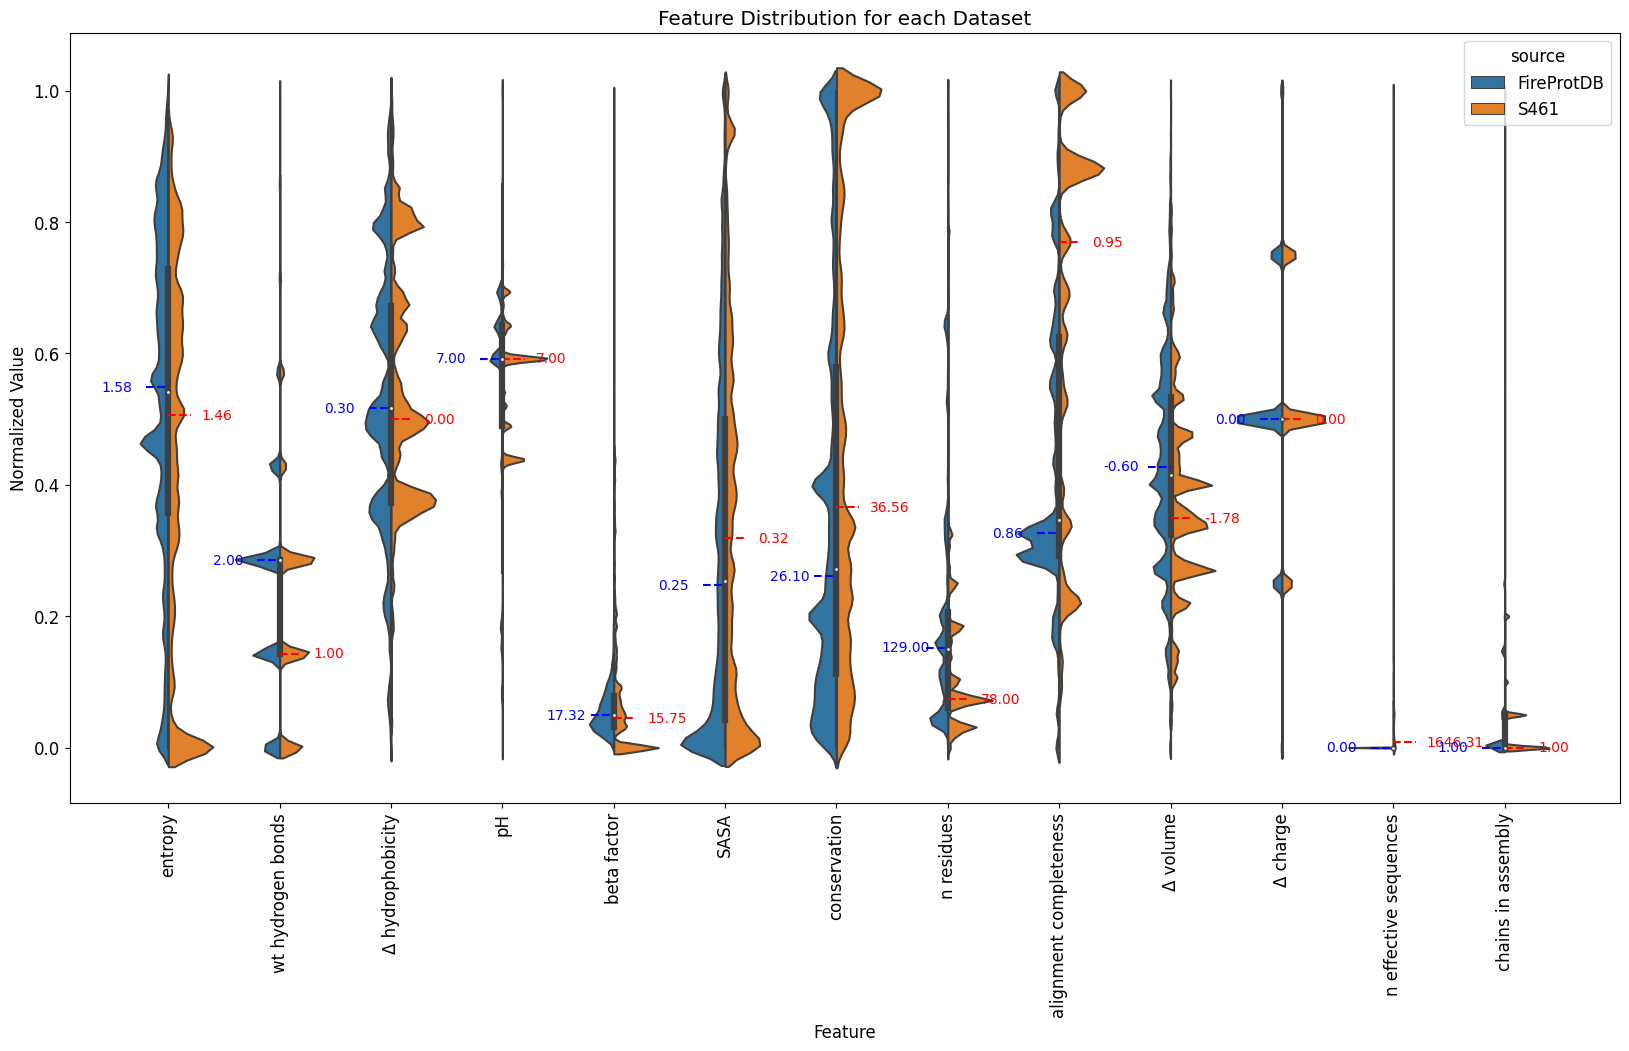

In [ ]:
# SUPPLEMENTARY FIGURE 10

compare_distributions_violin(fp_feats.drop(['n_seqs', 'on_interface', 'column_completeness', 'saltbrs'], axis=1), s461_feats)

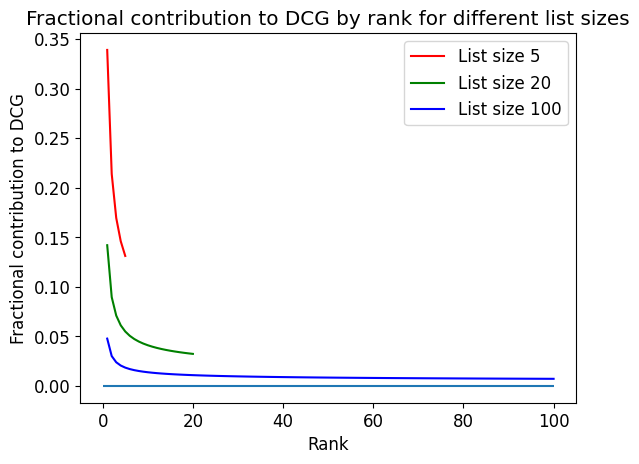

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def fractional_contributions(list_size, base=2):
    ranks = np.arange(1, list_size+1)
    discounts = 1 / np.log2(ranks + 1)  # compute the discount for each rank
    return discounts / np.sum(discounts)  # normalize to get fractional contributions

list_sizes = [5, 20, 100]
colors = ['r', 'g', 'b']

for i, list_size in enumerate(list_sizes):
    fractions = fractional_contributions(list_size)
    plt.plot(np.arange(1, list_size+1), fractions, color=colors[i], label=f'List size {list_size}')

plt.xlabel('Rank')
plt.ylabel('Fractional contribution to DCG')
plt.title('Fractional contribution to DCG by rank for different list sizes')
plt.hlines(0, 0, 100)
plt.legend()
plt.show()

In [ ]:
# The following cells are extra analyses not included in the paper

In [ ]:
custom_colors = {#'cartesian_ddg_dir + esmif_multimer_dir * 0.5': 'black',
                 #'mpnn_20_00_dir + esmif_multimer_dir * 1': 'black',
                 'cartesian_ddg_dir': 'red',
                 #'monomer_ddg_dir': 'red',
                 'korpm_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 'msa_transformer_mean_dir': 'green',
                 #'msa_transformer_median_dir': 'green',
                 'tranception_dir': 'green',
                 #'tranception_dir': 'green',
                 #'esmif_monomer_dir': 'red',
                 #'esmif_multimer_dir': 'red',
                 'esmif_multimer_dir': 'red',
                 #'esmif_monomer_masked_dir': 'red',
                 'mpnn_mean_dir': 'red',
                 #'mpnn_10_00_dir': 'red',
                 #'mpnn_20_00_dir': 'red',
                 #'mpnn_20_mean_dir': 'red',
                 #'mpnn_30_noise_dir': 'red',
                 #'mpnn_20_02_dir': 'red',
                 #'mpnn_30_03_dir': 'red',
                 #'mpnn_30_03_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'purple',
                 'ddG_dir': 'grey',
                 'mpnn_mean_dir + cartesian_ddg_dir * 1': 'red',
                 'mpnn_mean_dir + korpm_dir * 1': 'red'}

db_complete = db_preds.join(db_measurements, how='left').drop(['ProTherm', 'FireProt', 'is_curated', 'ThermoFluor'], axis=1).join(db_feats_2, how='left').drop_duplicates().drop('code', axis=1).dropna(subset='korpm_dir').dropna(subset='msa_transformer_mean_dir')
db_complete = dfm.drop('code', axis=1)[list(custom_colors.keys())+['ddG', 'dTm']]
analysis_utils.compute_stats(db_complete, stats=('n', 'mean_stabilization', 'pred_positives'), measurements=['ddG', 'dTm']).drop('runtime', axis=1)

Average prediction for stabilized protein: -0.49609476646840933
Average experimental value for predicted stabilized: 0.3340901360544218


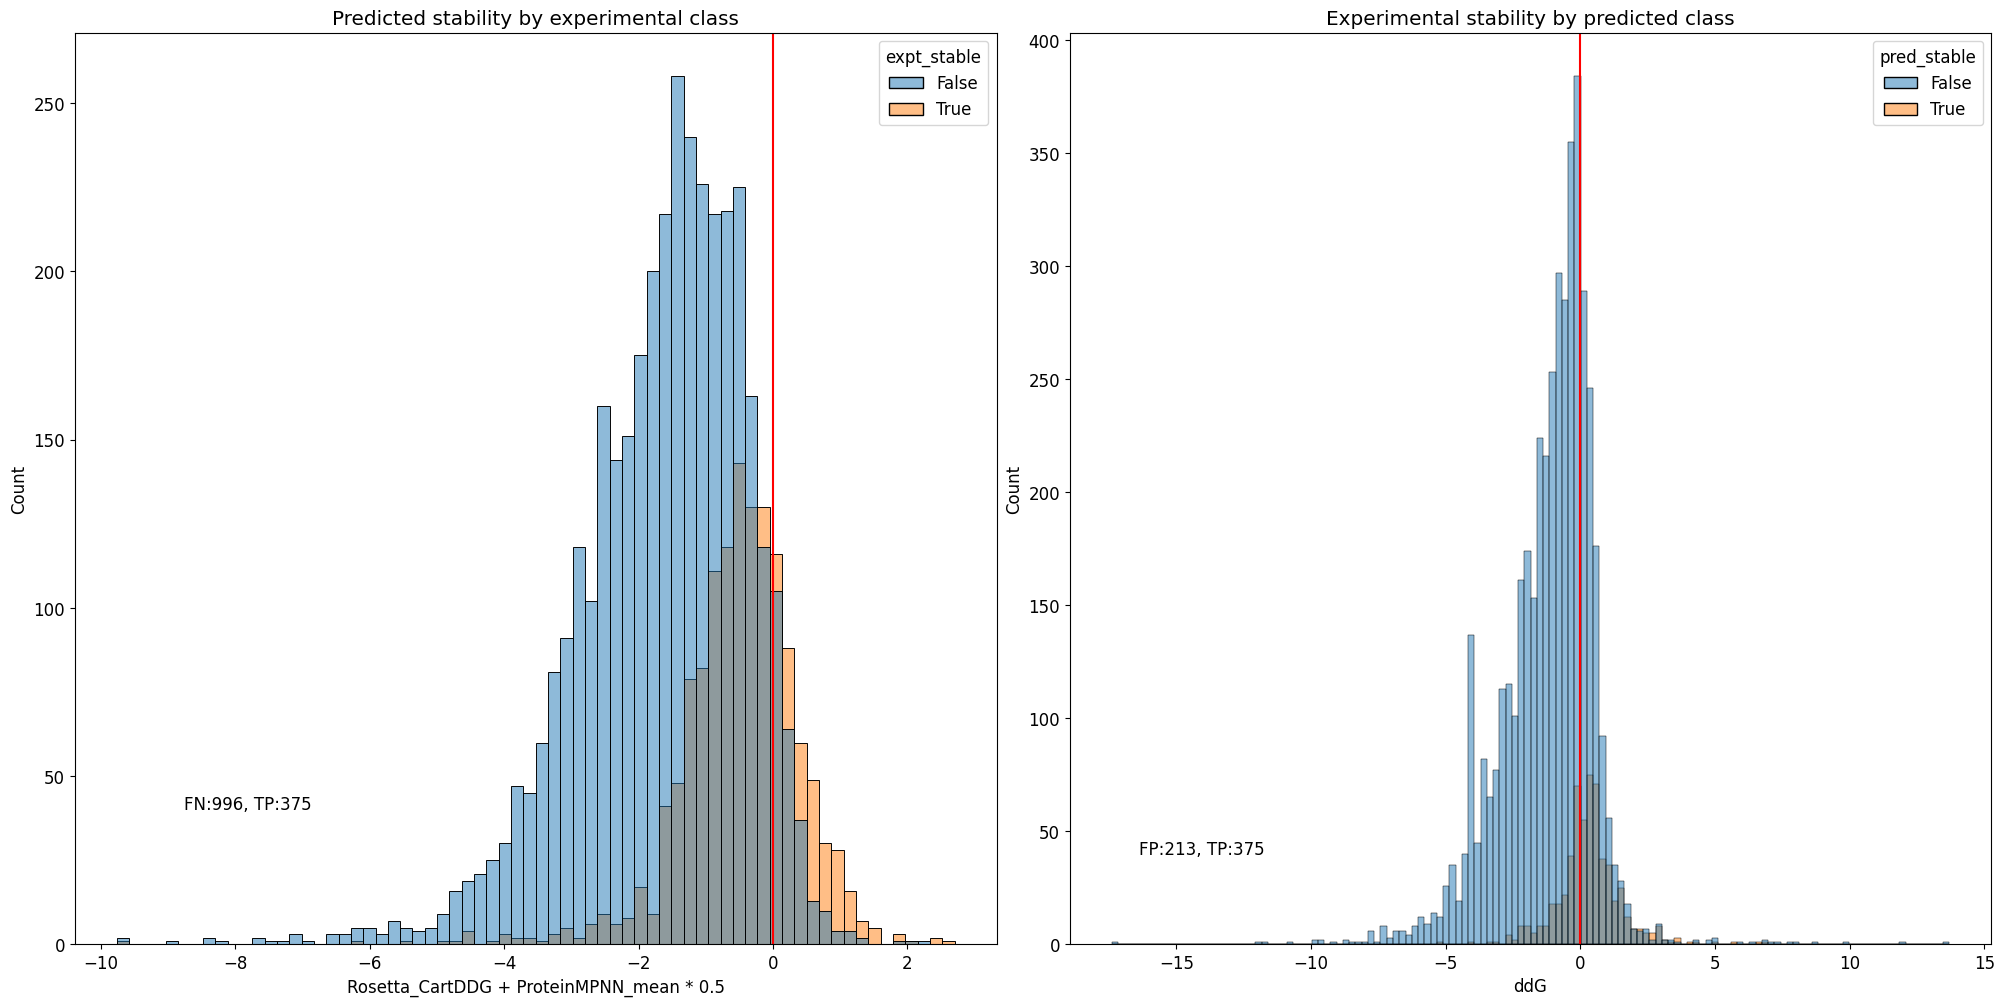

n_expt_stable                          1371.000000
P(pred_stable|stable) - sensitivity       0.273523
P(pred_stable|unstable) - FPR             0.058007
n_pred_stable                           588.000000
P(stable|pred_stable) - PPV               0.670068
P(stable|pred_unstable) - FOR             0.237486
dtype: float64

In [ ]:
def compare_stable_dists(db_complete, score_name, decision_threshold_ddg=0, decision_threshold_score=0, x_label_1=None):

    dbf = db_complete.copy(deep=True)
    dbf = dbf.loc[:, [score_name, 'ddG']]
    min_score = dbf[score_name].min() + 1
    min_ddg = dbf['ddG'].min() + 1

    # todo: add dTm
    df_out = pd.Series(index = ['n_expt_stable', 'P(pred_stable|stable) - sensitivity', 'P(pred_stable|unstable) - FPR',\
                                 'n_pred_stable', 'P(stable|pred_stable) - PPV', 'P(stable|pred_unstable) - FOR'], dtype=float)
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    #fig.suptitle(score_name)
    axs[0].set_title(f'Predicted stability by experimental class')
    axs[1].set_title(f'Experimental stability by predicted class')

    stable = dbf.loc[dbf['ddG'] > decision_threshold_ddg, :].dropna().copy()
    stable['expt_stable'] = True
    unstable = dbf.loc[dbf['ddG'] <= decision_threshold_ddg, :].dropna().copy()
    unstable['expt_stable'] = False
    to_plot = pd.concat([stable, unstable])

    df_out['n_expt_stable'] = len(stable)
    df_out['P(pred_stable|stable) - sensitivity'] = len(stable.loc[stable[score_name] >= decision_threshold_score]) / len(stable)
    df_out['P(pred_stable|unstable) - FPR'] = len(unstable.loc[unstable[score_name] >= decision_threshold_score]) / len(unstable)

    left = len(stable.loc[stable[score_name] <= decision_threshold_score])
    right = len(stable.loc[stable[score_name] > decision_threshold_score])
    sns.histplot(ax=axs[0], data=to_plot, x=score_name, hue='expt_stable')
    axs[0].annotate(f'FN:{left}, TP:{right}', xy=(min_score,40))
    axs[0].axvline(x = decision_threshold_score, color = 'r', label = 'axvline - full height')
    axs[0].set_xlabel(x_label_1)

    avg = stable[score_name].mean()
    print('Average prediction for stabilized protein:', avg)

    predicted_stable = dbf.loc[dbf[score_name] > decision_threshold_score, :].dropna().copy()
    predicted_stable['pred_stable'] = True
    predicted_unstable = dbf.loc[dbf[score_name] <= decision_threshold_score, :].dropna().copy()
    predicted_unstable['pred_stable'] = False
    to_plot = pd.concat([predicted_stable, predicted_unstable])

    df_out['n_pred_stable'] = len(predicted_stable)
    df_out['P(stable|pred_stable) - PPV'] = len(predicted_stable.loc[predicted_stable['ddG'] >= decision_threshold_ddg]) / len(predicted_stable)
    df_out['P(stable|pred_unstable) - FOR'] = len(predicted_unstable.loc[predicted_unstable['ddG'] >= decision_threshold_ddg]) / len(predicted_unstable)
    
    left = len(predicted_stable.loc[predicted_stable['ddG'] <= decision_threshold_ddg])
    right = len(predicted_stable.loc[predicted_stable['ddG'] > decision_threshold_ddg])
    sns.histplot(ax=axs[1], data=to_plot, x='ddG', hue='pred_stable')
    axs[1].annotate(f'FP:{left}, TP:{right}', xy=(min_ddg,40))
    axs[1].axvline(x = decision_threshold_ddg, color = 'r', label = 'axvline - full height')

    avg = predicted_stable['ddG'].mean()
    print('Average experimental value for predicted stabilized:', avg)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

    return df_out

s = dfm.drop(['ProTherm', 'FireProt', 'ThermoFluor'], axis=1).drop_duplicates().drop('code', axis=1).dropna(subset='korpm_dir') #.join(db_feats_2, how='left')
compare_stable_dists(s, 'cartesian_ddg_dir + mpnn_mean_dir * 0.5', decision_threshold_ddg=0, decision_threshold_score=0, x_label_1='Rosetta_CartDDG + ProteinMPNN_mean * 0.5')